# Renewind

## Problem Statement

**Context**

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S. Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).

**Objective**:

“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data on generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set, and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators can be repaired before failing/breaking to reduce the overall maintenance cost.

The nature of predictions made by the classification model will translate as follows:
- True positives (TP) are failures correctly predicted by the model. These will result in repair costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variable should be considered as “failure” and “0” represents “No failure”.

**Data Description**

The data provided is a transformed version of the original data which was collected using sensors.

- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.

Both datasets consist of 40 predictor variables and 1 target variable.

### 🔭 Grokking the Problem !!

**BirdEye** 👀

We are predicting wind turbine generator failures based on sensor data.


- This is the binary classification task
- **Target**: 1 = failure, 0 = no failure
- Data: **40** anonymized (ciphered) features → likely continuous/numerical
- **Training set**: 20,000 samples
- **Test set**: 5,000 samples

🔍 Failures are rare (likely), so class imbalance is an expected issue. Also, costs of mistakes are asymmetric:

- FN (missed failure) → very bad → expensive replacement
- FP (false alarm) → tolerable → inspection cost
- TP (correctly flagged failure) → good → repair cost

> Business context highly penalizes the False Negatives (FN) -> replacement cost is very high !

📌 GOAL :- So our model should:

- Catch as many failures as possible
- Avoid too many false alarms, but FN is more dangerous than FP

⚡ Metric to focus on :

- Recall
- F2-Score  // emphasis recall over precision

> It's okay if some false alarms happens, as long as ain't miss actual failures.

### Preparation

In [1]:
# verify
import sys
print(sys.executable, sys.version)

/Users/nipunshah/anaconda3/bin/python 3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]


In [206]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tabulate as tb

# Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score
from sklearn.utils.class_weight import compute_class_weight



In [3]:
# Global options and themes

# Set pandas display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)      # Show 100 rows by default

# Seaborn theme for consistent plotting style
sns.set_theme(style="whitegrid", palette="muted", context="notebook")  # You can change it to darkgrid, ticks, etc.
plt.rcParams["figure.figsize"] = (15, 6)  # Set default figure size for plots
plt.rcParams["font.size"] = 14            # Set font size for readability

# restrict float display to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

In [44]:
# Helpers
def tb_describe(df_col):
    """
    Helper function to display descriptive statistics in a nicely formatted table

    Parameters:
    df_col : pandas Series or DataFrame column
        The column to generate descriptive statistics for

    Returns:
    None - prints formatted table
    """
    stats = df_col.describe().to_frame().T
    print(tb.tabulate(stats, headers='keys', tablefmt='simple', floatfmt='.2f'))

# Primitive Utils
def snake_to_pascal(snake_str, join_with=" "):
    """Convert snake_case to PascalCase (eg my_name -> MyName)
    Args:
        snake_str (str): string to convert
        join_with (str): character to join the components, default is space
    """
    components = snake_str.split("_")
    return join_with.join(x.title() for x in components)


def format_pct(val):
    """Format a val as percentage i.e max 2 decimal value & adding % at the end"""
    return f"{val:.1f}%"

def to_percentage(value):
    """value is expected to be a normalized float value in [0, 1]"""
    return format_pct(value * 100)

def calc_iqr(series: pd.Series):
    """
    series: array of numerical values
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return Q1, Q3, IQR

def count_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return ((series < lower_bound) | (series > upper_bound)).sum()

In [1]:
def shout(tag, *args):
    print(f"[{tag}]", *args)

In [2]:
tag = 'NN'

In [7]:
# list all files in current directory
!ls

Test.csv           Train.csv          notebook_eda.ipynb strategy


## Data Check (Sanity)

In [8]:
# Load the data
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')

In [9]:
# backup original data
train_df = train_data.copy()
test_df = test_data.copy()

In [12]:
# Basic information about the datasets
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (20000, 41)
Test data shape: (5000, 41)


In [10]:
# Peek first few rows
train_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.46,-4.68,3.10,0.51,-0.22,-2.03,-2.91,0.05,-1.52,3.76,-5.71,0.74,0.98,1.42,-3.38,-3.05,0.31,2.91,2.27,4.39,-2.39,0.65,-1.19,3.13,0.67,-2.51,-0.04,0.73,-3.98,-1.07,1.67,3.06,-1.69,2.85,2.24,6.67,0.44,-2.37,2.95,-3.48,0
1,3.37,3.65,0.91,-1.37,0.33,2.36,0.73,-4.33,0.57,-0.10,1.91,-0.95,-1.26,-2.71,0.19,-4.77,-2.21,0.91,0.76,-5.83,-3.07,1.60,-1.76,1.77,-0.27,3.63,1.50,-0.59,0.78,-0.20,0.02,-1.80,3.03,-2.47,1.89,-2.30,-1.73,5.91,-0.39,0.62,0
2,-3.83,-5.82,0.63,-2.42,-1.77,1.02,-2.10,-3.17,-2.08,5.39,-0.77,1.11,1.14,0.94,-3.16,-4.25,-4.04,3.69,3.31,1.06,-2.14,1.65,-1.66,1.68,-0.45,-4.55,3.74,1.13,-2.03,0.84,-1.60,-0.26,0.80,4.09,2.29,5.36,0.35,2.94,3.84,-4.31,0
3,1.62,1.89,7.05,-1.15,0.08,-1.53,0.21,-2.49,0.34,2.12,-3.05,0.46,2.70,-0.64,-0.45,-3.17,-3.40,-1.28,1.58,-1.95,-3.52,-1.21,-5.63,-1.82,2.12,5.29,4.75,-2.31,-3.96,-6.03,4.95,-3.58,-2.58,1.36,0.62,5.55,-1.53,0.14,3.10,-1.28,0
4,-0.11,3.87,-3.76,-2.98,3.79,0.54,0.21,4.85,-1.85,-6.22,2.00,4.72,0.71,-1.99,-2.63,4.18,2.25,3.73,-6.31,-5.38,-0.89,2.06,9.45,4.49,-3.95,4.58,-8.78,-3.38,5.11,6.79,2.04,8.27,6.63,-10.07,1.22,-3.23,1.69,-2.16,-3.64,6.51,0


In [11]:
# Peek first few rows
test_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.61,-3.82,2.20,1.30,-1.18,-4.50,-1.84,4.72,1.21,-0.34,-5.12,1.02,4.82,3.27,-2.98,1.39,2.03,-0.51,-1.02,7.34,-2.24,0.16,2.05,-2.77,1.85,-1.79,-0.28,-1.26,-3.83,-1.50,1.59,2.29,-5.41,0.87,0.57,4.16,1.43,-10.51,0.45,-1.45,0
1,0.39,-0.51,0.53,-2.58,-1.02,2.24,-0.44,-4.41,-0.33,1.97,1.80,0.41,0.64,-1.39,-1.88,-5.02,-3.83,2.42,1.76,-3.24,-3.19,1.86,-1.71,0.63,-0.59,0.08,3.01,-0.18,0.22,0.87,-1.78,-2.47,2.49,0.32,2.06,0.68,-0.49,5.13,1.72,-1.49,0
2,-0.87,-0.64,4.08,-1.59,0.53,-1.96,-0.70,1.35,-1.73,0.47,-4.93,3.57,-0.45,-0.66,-0.17,-1.63,2.29,2.40,0.60,1.79,-2.12,0.48,-0.84,1.79,1.87,0.36,-0.17,-0.48,-2.12,-2.16,2.91,-1.32,-3.00,0.46,0.62,5.63,1.32,-1.75,1.81,1.68,0
3,0.24,1.46,4.01,2.53,1.20,-3.12,-0.92,0.27,1.32,0.70,-5.58,-0.85,2.59,0.77,-2.39,-2.34,0.57,-0.93,0.51,1.21,-3.26,0.10,-0.66,1.50,1.10,4.14,-0.25,-1.14,-5.36,-4.55,3.81,3.52,-3.07,-0.28,0.95,3.03,-1.37,-3.41,0.91,-2.45,0
4,5.83,2.77,-1.23,2.81,-1.64,-1.41,0.57,0.97,1.92,-2.77,-0.53,1.37,-0.65,-1.68,-0.38,-4.44,3.89,-0.61,2.94,0.37,-5.79,4.60,4.45,3.22,0.40,0.25,-2.36,1.08,-0.47,2.24,-3.59,1.77,-1.50,-2.23,4.78,-6.56,-0.81,-0.28,-3.86,-0.54,0


In [24]:
# Check data types and missing values
print("\nUnique datatypes amongs all columns:")

# print unique datatypes amongs all columns
train_df.dtypes.unique()


Unique datatypes amongs all columns:


array([dtype('float64'), dtype('int64')], dtype=object)

In [25]:
print("\nColumns Summary:")

summary = pd.DataFrame({
    "Column": train_df.columns,
    "Dtype": train_df.dtypes.values,
    "Missing": train_df.isnull().sum().values,
    "Unique": train_df.nunique().values
})

# Columns Summary
summary



Columns Summary:


,Column,Dtype,Missing,Unique
0,V1,float64,18,19982
1,V2,float64,18,19982
2,V3,float64,0,20000
3,V4,float64,0,20000
4,V5,float64,0,20000
5,V6,float64,0,20000
6,V7,float64,0,20000
7,V8,float64,0,20000
8,V9,float64,0,20000
9,V10,float64,0,20000


🧐 Key observations:

- All columns are of numeric type, where target is already in desired fashion (ie 1/0)
- Only V1 and V2 have missing values (18 each), rest of columns have no missing data
- All features have high cardinality with ~20k unique values, while Target is binary (2 unique values)

In [26]:
# Summary statistics
print("\nSummary statistics for training data:")
display(train_df.describe())


Summary statistics for training data:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,19982.00,19982.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00
mean,-0.27,0.44,2.48,-0.08,-0.05,-1.00,-0.88,-0.55,-0.02,-0.01,-1.90,1.60,1.58,-0.95,-2.41,-2.93,-0.13,1.19,1.18,0.02,-3.61,0.95,-0.37,1.13,-0.00,1.87,-0.61,-0.88,-0.99,-0.02,0.49,0.30,0.05,-0.46,2.23,1.51,0.01,-0.34,0.89,-0.88,0.06
std,3.44,3.15,3.39,3.43,2.10,2.04,1.76,3.30,2.16,2.19,3.12,2.93,2.87,1.79,3.35,4.22,3.35,2.59,3.40,3.67,3.57,1.65,4.03,3.91,2.02,3.44,4.37,1.92,2.68,3.01,3.46,5.50,3.58,3.18,2.94,3.80,1.79,3.95,1.75,3.01,0.23
min,-11.88,-12.32,-10.71,-15.08,-8.60,-10.23,-7.95,-15.66,-8.60,-9.85,-14.83,-12.95,-13.23,-7.74,-16.42,-20.37,-14.09,-11.64,-13.49,-13.92,-17.96,-10.12,-14.87,-16.39,-8.23,-11.83,-14.90,-9.27,-12.58,-14.80,-13.72,-19.88,-16.90,-17.99,-15.35,-14.83,-5.48,-17.38,-6.44,-11.02,0.00
25%,-2.74,-1.64,0.21,-2.35,-1.54,-2.35,-2.03,-2.64,-1.49,-1.41,-3.92,-0.40,-0.22,-2.17,-4.42,-5.63,-2.22,-0.40,-1.05,-2.43,-5.93,-0.12,-3.10,-1.47,-1.37,-0.34,-3.65,-2.17,-2.79,-1.87,-1.82,-3.42,-2.24,-2.14,0.34,-0.94,-1.26,-2.99,-0.27,-2.94,0.00
50%,-0.75,0.47,2.26,-0.14,-0.10,-1.00,-0.92,-0.39,-0.07,0.10,-1.92,1.51,1.64,-0.96,-2.38,-2.68,-0.01,0.88,1.28,0.03,-3.53,0.97,-0.26,0.97,0.03,1.95,-0.88,-0.89,-1.18,0.18,0.49,0.05,-0.07,-0.26,2.10,1.57,-0.13,-0.32,0.92,-0.92,0.00
75%,1.84,2.54,4.57,2.13,1.34,0.38,0.22,1.72,1.41,1.48,0.12,3.57,3.46,0.27,-0.36,-0.10,2.07,2.57,3.49,2.51,-1.27,2.03,2.45,3.55,1.40,4.13,2.19,0.38,0.63,2.04,2.73,3.76,2.26,1.44,4.06,3.98,1.18,2.28,2.06,1.12,0.00
max,15.49,13.09,17.09,13.24,8.13,6.98,8.01,11.68,8.14,8.11,11.83,15.08,15.42,5.67,12.25,13.58,16.76,13.18,13.24,16.05,13.84,7.41,14.46,17.16,8.22,16.84,17.56,6.53,10.72,12.51,17.26,23.63,16.69,14.36,15.29,19.33,7.47,15.29,7.76,10.65,1.00


🧐 Key observations :
- Most features have mean close to 0 and standard deviation between 2-4, suggesting standardized/normalized data
- Features show wide ranges with some having extreme min/max values (eg. V8: -15.66 to 23.63)
- There are -ve values too for various columns 

In [29]:
# Target variable distribution
print("\nTarget variable distribution:")
train_df['Target'].value_counts()


Target variable distribution:


0    18890
1     1110
Name: Target, dtype: int64

In [30]:
# Target variable distribution with percentage
print("\nTarget variable distribution with percentage:")
train_df['Target'].value_counts(normalize=True)



Target variable distribution with percentage:


0   0.94
1   0.06
Name: Target, dtype: float64

🧐 Key observations about Target distribution:
- The dataset is highly imbalanced with class 0 (No Repair needed) being 94% of the data
- Only 6% of samples belong to class 1 (Repair needed)
- This severe class imbalance (ratio ~16:1) suggests we'll need to:
  1. Use appropriate evaluation metrics (e.g. Recall, F2-Score) instead of just accuracy
  2. Consider techniques like oversampling, undersampling or SMOTE during modeling
  3. **Potentially use class weights to handle the imbalance**

🧠 **Class Imbalance: 96% (0) vs 6% (1)**

This is a significant imbalance, and here's how it affects FFNNs:

❌ If we do nothing:

- Model likely predicts class 0 always → high accuracy, poor recall for class 1 (failures).

So we have 2 options sampling and class weights

Let's Use class_weight during training
-> This is preferred over sampling in neural nets as it:
- Preserves full data
- Avoids synthetic noise
- Focuses model to penalize mistakes on minority class more heavily

> Let's Monitor metrics like F1 / F2 / Recall, not accuracy.


In [28]:
# Missing values (Overall)
print("\nMissing values (Overall):")
missing_values = train_df.isnull().sum().sum()
missing_values



Missing values (Overall):


36

In [31]:
# Check for duplicate rows
print("\nNumber of duplicate rows in training data:", train_data.duplicated().sum())


Number of duplicate rows in training data: 0


No duplicates entries (hence data is solid)

#### **Check for Correlation**

In [43]:
# Check for highly correlated features
print("\nChecking for highly correlated features...(threshold = 0.8)")
correlation_matrix = train_data.corr(numeric_only=True)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # Threshold for high correlation
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print('Done !!')
print('Highly correlated features:')
high_corr_pairs


Checking for highly correlated features...(threshold = 0.8)
Done !!
Highly correlated features:


[('V14', 'V2', -0.853530003549924),
 ('V15', 'V7', 0.8678709232567364),
 ('V16', 'V8', 0.8025054949614852),
 ('V21', 'V16', 0.8365265817081082),
 ('V29', 'V11', 0.8112280237988402),
 ('V32', 'V24', 0.8251193475710307)]

In [42]:
# Check for highly correlated features
print("\nChecking for Very Strong correlated features... (threshold = 0.9)")
correlation_matrix = train_data.corr(numeric_only=True)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:  # Threshold for high correlation
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print('Done !!')
print('Highly correlated features:')
print(high_corr_pairs)


Checking for Very Strong correlated features...
Done !!
Highly correlated features:
[]


🧐 Key observations about Correlated Features:

- At **threshold 0.8** → got bunch of pairs.
- At **threshold 0.9 **→ You get none.

✅ Insights

- No very strong correlation (≥ 0.9) — so no features are near-duplicates.
- Some moderate-to-strong correlation (≥ 0.8) — but not extreme.

🧠 From Neural Network Point of View:

- Neural networks can handle correlated features better than linear models.
- They learn nonlinear combinations, so multicollinearity isn’t fatal.
- But very high redundancy (like 0.95+) could slow learning or introduce noise

> As no pairs >= 0.9, no need to drop any features in Feature Engineering

💡 **Just need to normalize input later before feeding to the NN (important!).**

🧠 **Use correlated pairs strategically in EDA:**

Since full EDA on 40 features is too much, this gives you a guided shortlist.

- High correlation implies shared or related behavior.
- Can help detect feature clusters, trends, or hidden structure.
- Useful to check: Do they relate differently to the target (failure vs no failure)?

In [38]:
# Let's pick any 2 column and see correlation
print('Correlation between V1 and V2:')
correlation_matrix.loc["V1", "V2"]  # returns correlation coefficient between V1 and V2


Correlation between V1 and V2:


0.31359300207525387

#### **Outliers**

NOTE: 5% is common threshold generally used for an outlier detection

In [45]:
# Check for outliers in features
print("\nChecking for outliers in numerical features...")
outlier_counts = {col: count_outliers(train_data[col]) for col in train_data.select_dtypes(include=np.number).columns}
outlier_pct = {col: count/len(train_data)*100 for col, count in outlier_counts.items()}
print("Features with >5% outliers:")
for col, pct in outlier_pct.items():
    if pct > 5:
        print(f"{col}: {pct:.2f}%")


Checking for outliers in numerical features...
Features with >5% outliers:
Target: 5.55%


👀 Observations:

Thus from Predictor none of them have >5% outliers atleast

🧠  Just normalize later - no action needed now.

## EDA

❗ NOTE: 

We're focusing on the features that are highly related to each other, as found earlier, because they’re likely telling a similar story. Instead of randomly picking from all 40 features, this helps us explore the most meaningful ones first, saving time and giving better insights early on.

By examining these specific pairs
- Understand how related measurements behave together
- See if these correlations differ between failure/non-failure cases

This targeted approach gives you more meaningful insights than random exploration when dealing with many anonymized features.

Columns to focus on: 

a. 🔗 Correlated Pairs
- V16, V21, V14, V2, V15, V7, V29, V11, V32, V24

b. ⚠️ Missing Values Columns

- V1, V2

> these are high-value targets for smart EDA.

### Univariate Analysis

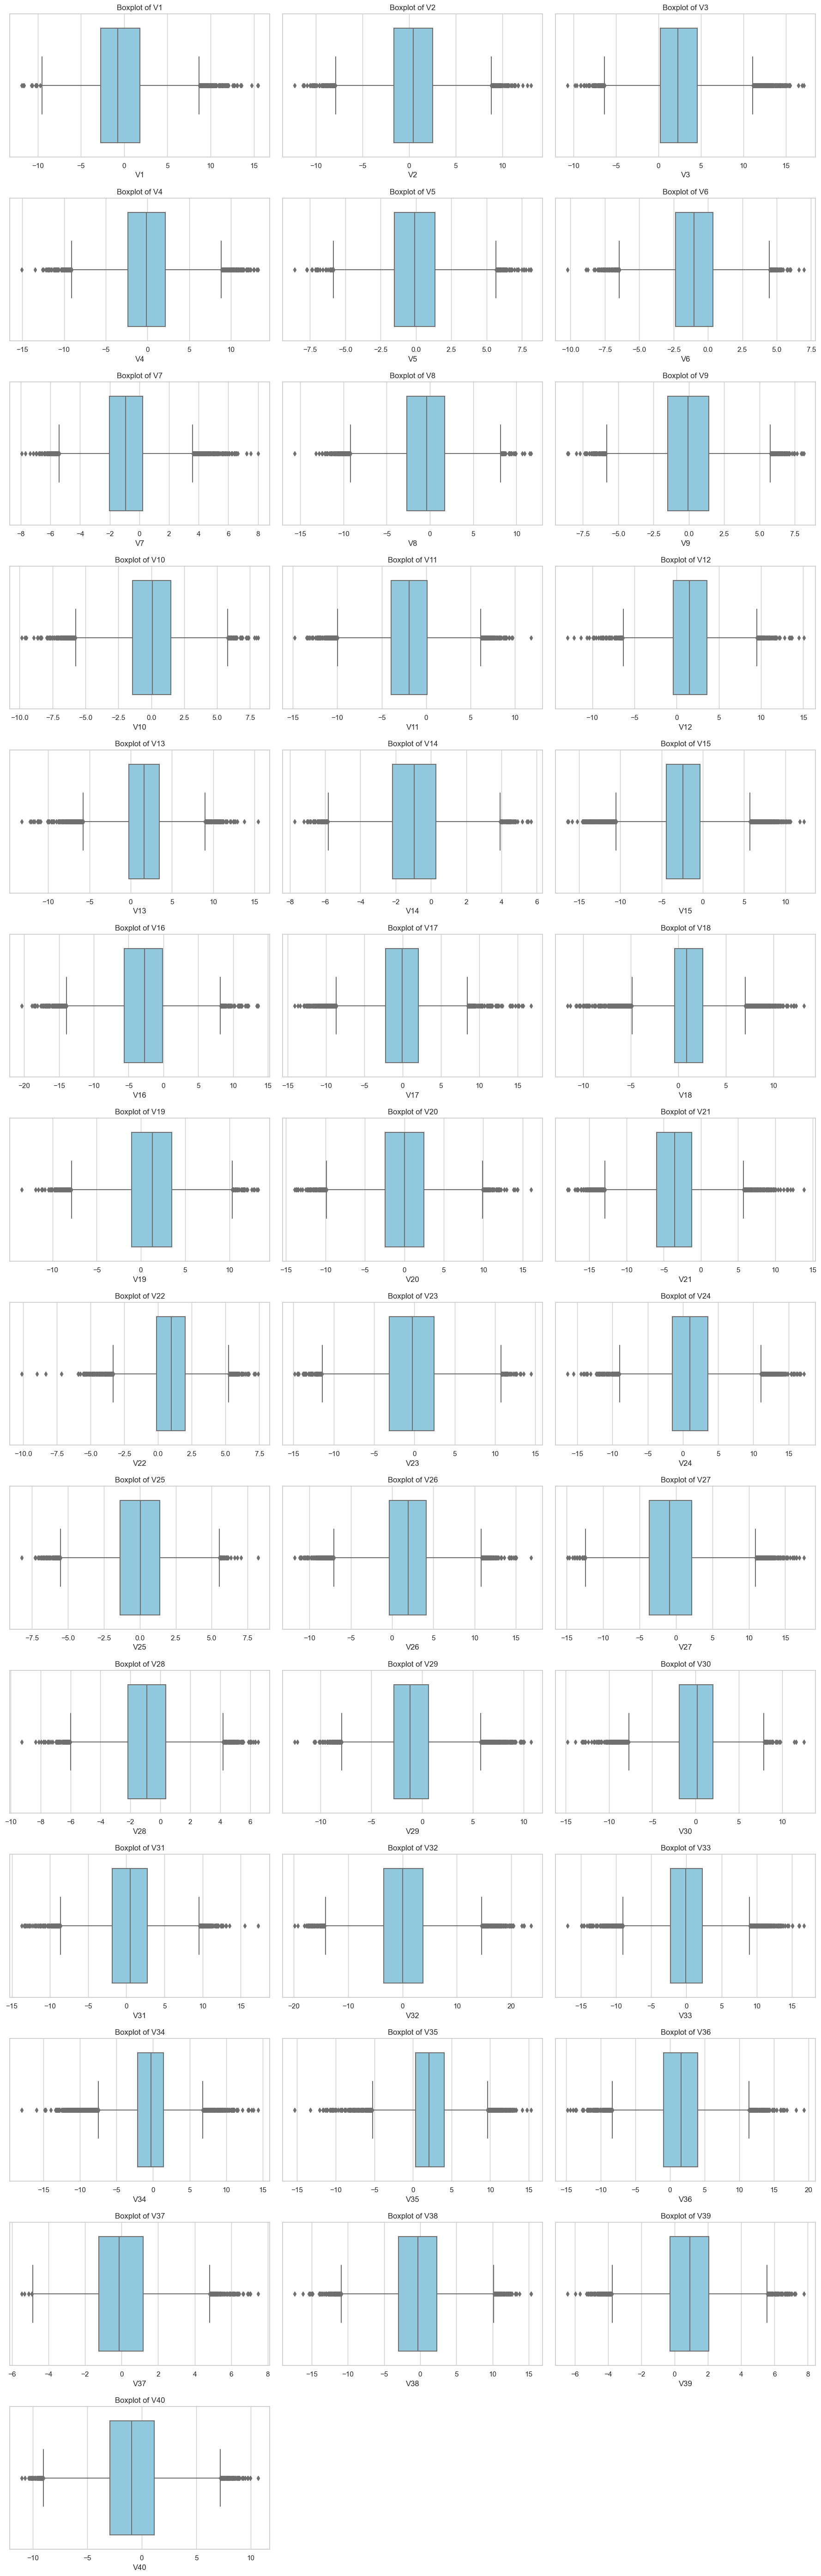

In [59]:
# Lets print box plot for all columns (to see outliers and distribution)

# Select only predictor columns (excluding target)
predictor_columns = train_df.drop(columns=['Target']).columns

# Plot settings
n_cols = 3
n_rows = int(len(predictor_columns) / n_cols) + 1
plt.figure(figsize=(18, n_rows * 4))

for i, col in enumerate(predictor_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=train_df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

##### Helper Methods

In [72]:
# Helper method

def plot_boxplot_by_target(df, feature):
    """
    Create boxplot comparing feature distribution across target classes

    Args:
        df: DataFrame containing the data
        feature: Name of feature column to plot
    """
    sns.boxplot(x='Target', y=feature, data=df)
    plt.title(f'{feature} Distribution by Target Class')
    plt.xlabel('Target (0=No Failure, 1=Failure)')
    plt.ylabel(f'{feature}')

def plot_histogram_with_density(df, feature):
    """
    Create histogram with density plot for a feature

    Args:
        df: DataFrame containing the data
        feature: Name of feature column to plot
    """
    sns.histplot(df, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')


In [76]:
def stats_by_target(df, feature):
    """
    Calculate descriptive statistics for a feature by target class
    """
    print(f"Stats of {feature} by target class:")
    print(df.groupby('Target')[feature].describe())


#### Feature V2

In [46]:
tb_describe(train_df['V2'])

       count    mean    std     min    25%    50%    75%    max
--  --------  ------  -----  ------  -----  -----  -----  -----
V2  19982.00    0.44   3.15  -12.32  -1.64   0.47   2.54  13.09


In [47]:
print('Skewness : ', train_df['V2'].skew())
print('Kurtosis : ', train_df['V2'].kurt())


Skewness :  -0.039033551968902264
Kurtosis :  0.08140674118140456


🔍 Summary Stats Interpretation for V2:

- Mean ~ 0.44 and Median (50%) ~ 0.47 -> data is fairly centered, little skew
- Std Dev ≈ 3.15 → moderate spread around mean.
- Range: From -12.32 to 13.09 → wide spread, but symmetric-looking.

🧐 Shape Indicators:

- Skewness ≈ -0.04 → Very close to zero, so almost symmetric distribution (neither heavy left nor right tail).
- Kurtosis ≈ 0.08 → Close to normal (0 for standard normal), suggests no heavy tails, not too peaky or flat.

**V2 is a nicely balanced, symmetric feature without extreme outliers or odd shape. It’s spread out, but doesn’t look problematic. Good candidate to check for signal against failure**

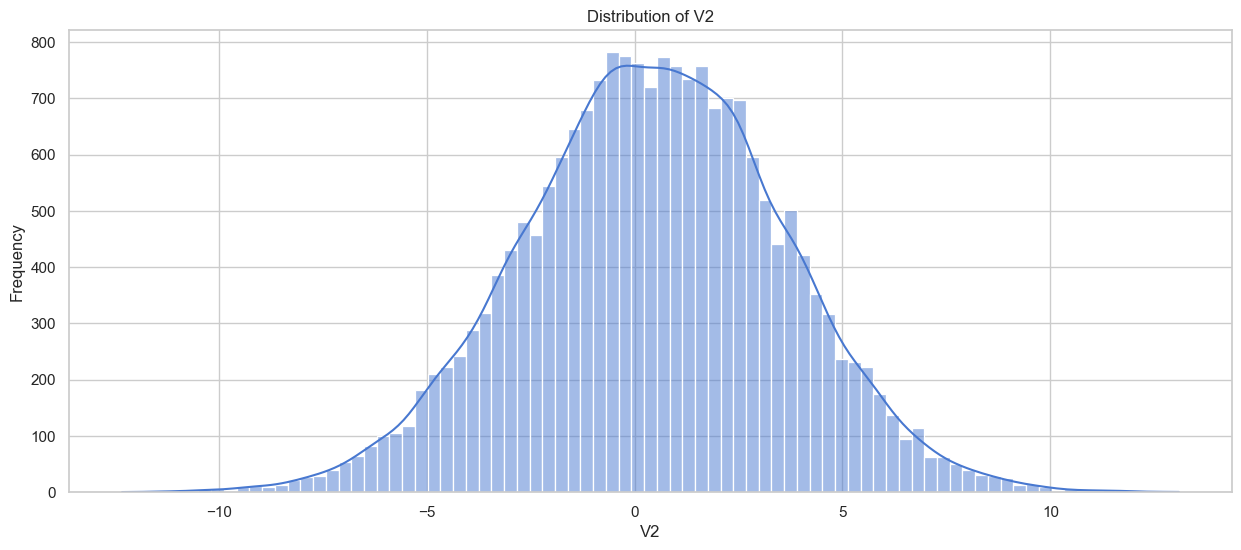

In [79]:
plot_histogram_with_density(train_df, 'V2')

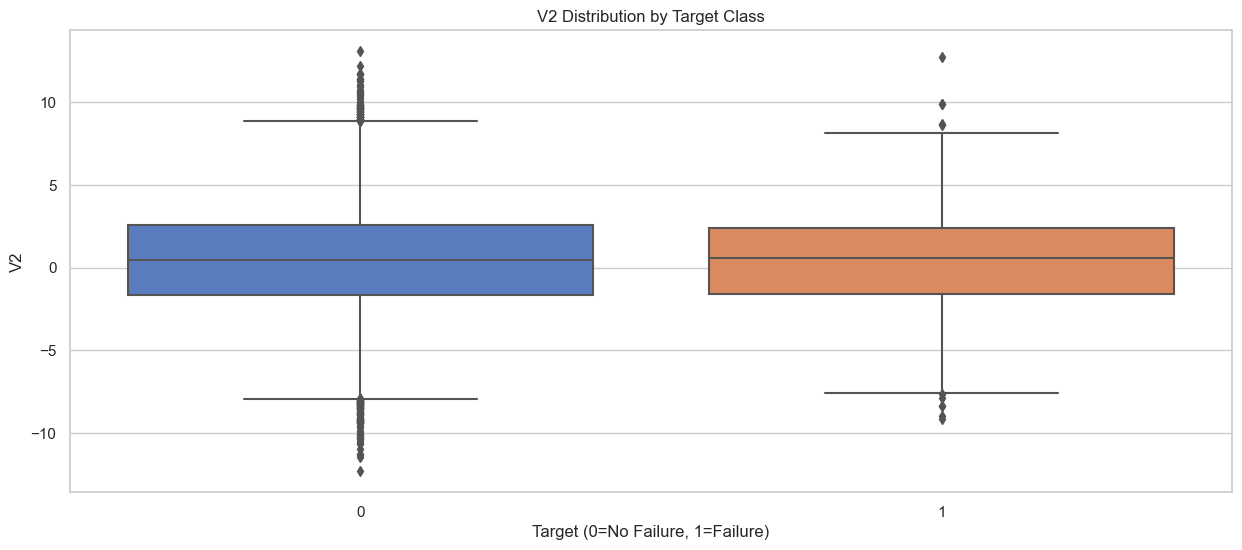

In [80]:
plot_boxplot_by_target(train_df, 'V2')

In [81]:
stats_by_target(train_df, 'V2')

Stats of V2 by target class:
          count  mean  std    min   25%  50%  75%   max
Target                                                 
0      18872.00  0.44 3.16 -12.32 -1.64 0.47 2.56 13.09
1       1110.00  0.43 3.01  -9.17 -1.60 0.56 2.40 12.72


🧐 Observations:

- Class 0 (No Failure) shows several notable outliers, particularly in both tails
- Most extreme outliers in Class 0 extend beyond ±10 units
- Class 1 (Failure) has fewer visible outliers

👀 Stats 

- Both classes have almost same mean (0.44, 0.43) but median shifts by a little (0.47, 0.56), comparatively

🤔 **NOTE: Means are very close, so mean imputation won't shift things much overall. hence we can use mean imputation later to impute missing values in V2 column**

#### Feature V1

In [64]:
tb_describe(train_df['V1'])

       count    mean    std     min    25%    50%    75%    max
--  --------  ------  -----  ------  -----  -----  -----  -----
V1  19982.00   -0.27   3.44  -11.88  -2.74  -0.75   1.84  15.49


In [65]:
print('Skewness : ', train_df['V1'].skew())
print('Kurtosis : ', train_df['V1'].kurt())


Skewness :  0.5451562083034572
Kurtosis :  0.17075677297637748


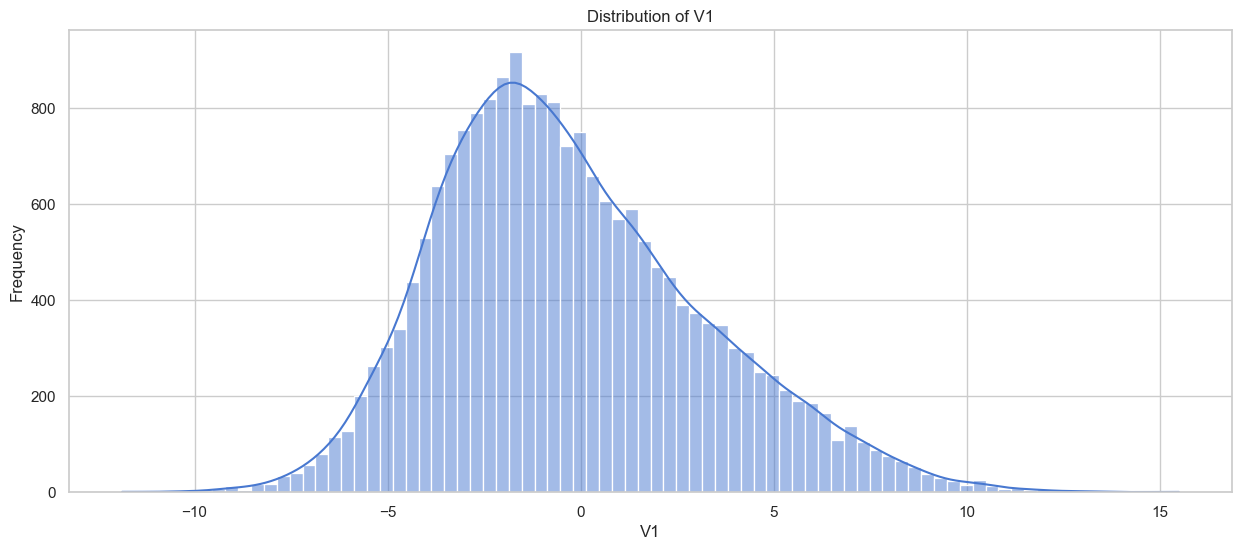

In [73]:
# 1. Histogram with density plot
plot_histogram_with_density(train_df, 'V1')

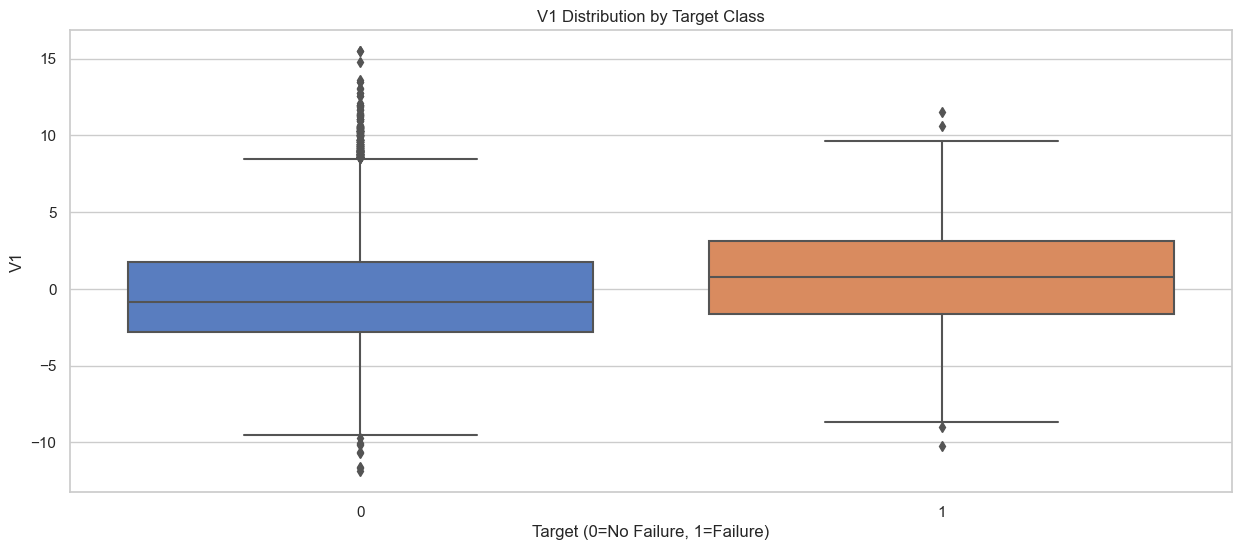

In [74]:
plot_boxplot_by_target(train_df, 'V1')

🧐 Observations:

- The bulk of data is on the left side, with a small stretch toward higher values.
- Failure category of V1 has slightly higher median than Non-Failure. 
- There's a noticeable difference between mean (-0.27) and median (-0.75)

In [77]:
stats_by_target(train_df, 'V1')

Stats of V1 by target class:
          count  mean  std    min   25%   50%  75%   max
Target                                                  
0      18872.00 -0.33 3.44 -11.88 -2.78 -0.84 1.73 15.49
1       1110.00  0.77 3.38 -10.26 -1.62  0.77 3.10 11.54


👀 Point: 

- notable deviations between central tendency for V1 feature by different classes
- V1 tends to be lower for healthy turbines (class 0) and higher for failing ones (class 1).
- **So, V1 has discriminative power — very useful feature for classification.**

💡 **Since there's a large mean/median gap between classes, global mean or median imputation would blur the signal. Hence, can try impute separately per class**

#### Feature V16

In [82]:
tb_describe(train_df['V16'])

        count    mean    std     min    25%    50%    75%    max
---  --------  ------  -----  ------  -----  -----  -----  -----
V16  20000.00   -2.93   4.22  -20.37  -5.63  -2.68  -0.10  13.58


In [83]:
print('Skewness : ', train_df['V16'].skew())
print('Kurtosis : ', train_df['V16'].kurt())

Skewness :  -0.21230343640385743
Kurtosis :  0.1677843363952598


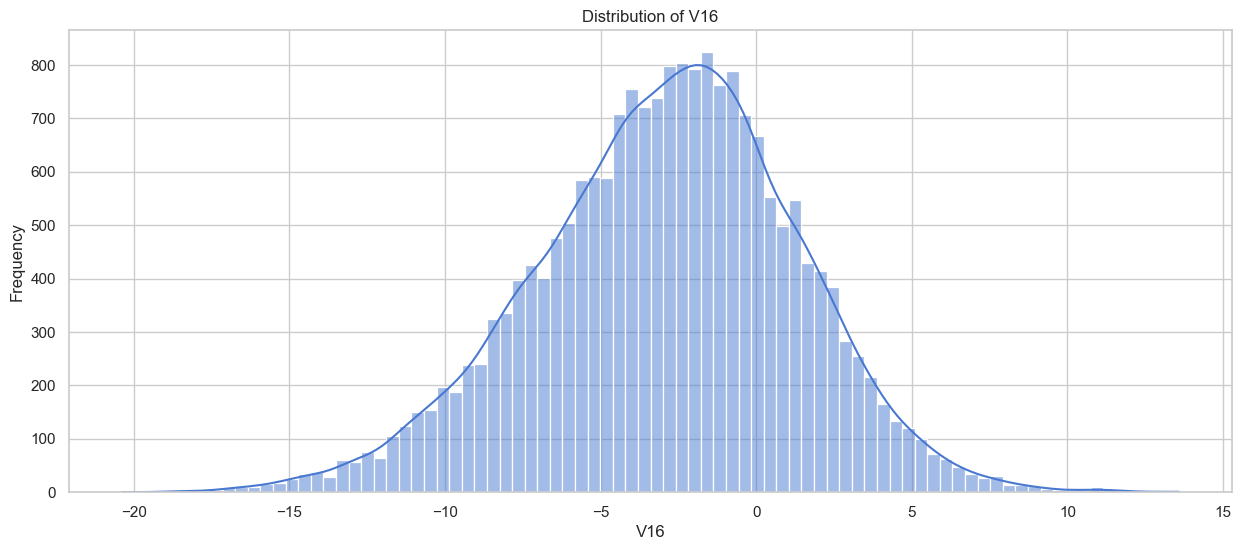

In [84]:
plot_histogram_with_density(train_df, 'V16')

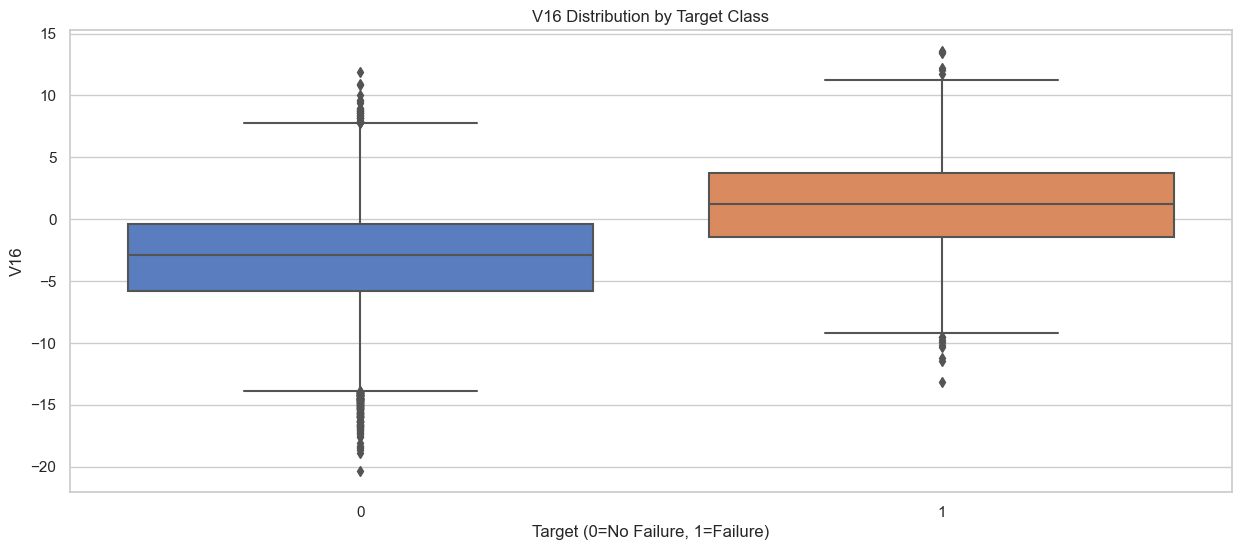

In [85]:
plot_boxplot_by_target(train_df, 'V16')

🧐 Observations: 

- Box plots show distinct central regions for class 0 vs class 1.
- V16 is fairly symmetric, well-spread.
- shows clear distinction across target classes, making it valuable for modeling.
- Wide range (-20.37 to 13.58) - The feature has a broad spread, suggesting it captures diverse operating conditions

#### Feature V21

In [87]:
tb_describe(train_df['V21'])

        count    mean    std     min    25%    50%    75%    max
---  --------  ------  -----  ------  -----  -----  -----  -----
V21  20000.00   -3.61   3.57  -17.96  -5.93  -3.53  -1.27  13.84


In [88]:
print('Skewness : ', train_df['V21'].skew())
print('Kurtosis : ', train_df['V21'].kurt())

Skewness :  -0.013268166477349621
Kurtosis :  0.3844618875552941


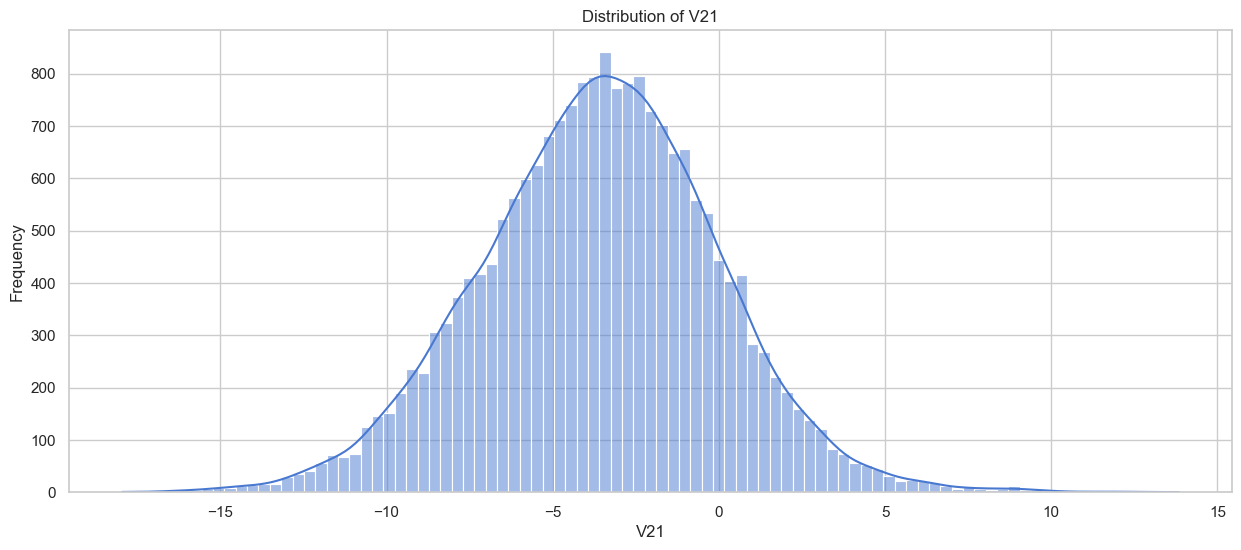

In [89]:
plot_histogram_with_density(train_df, 'V21')

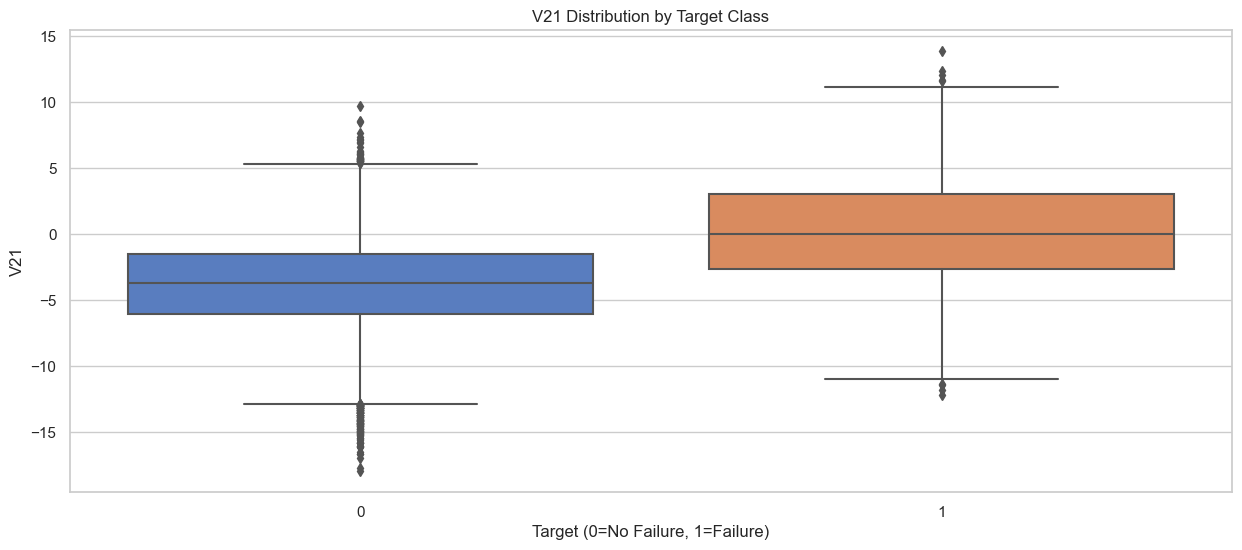

In [90]:
plot_boxplot_by_target(train_df, 'V21')

In [92]:
stats_by_target(train_df, 'V21')

Stats of V21 by target class:
          count  mean  std    min   25%   50%   75%   max
Target                                                   
0      18890.00 -3.83 3.40 -17.96 -6.04 -3.68 -1.49  9.69
1       1110.00  0.16 4.22 -12.20 -2.68  0.01  3.02 13.84


🧐 Observations

- Class 1 has higher standard deviation (4.22 vs 3.40), suggesting more variability, possibly due to fewer samples.
- **V21 shows clear separation between target classes, even though its overall distribution is symmetric. This makes it a strong feature for the model.**

### BiVariate Analysis

#### Feature V15 | Target

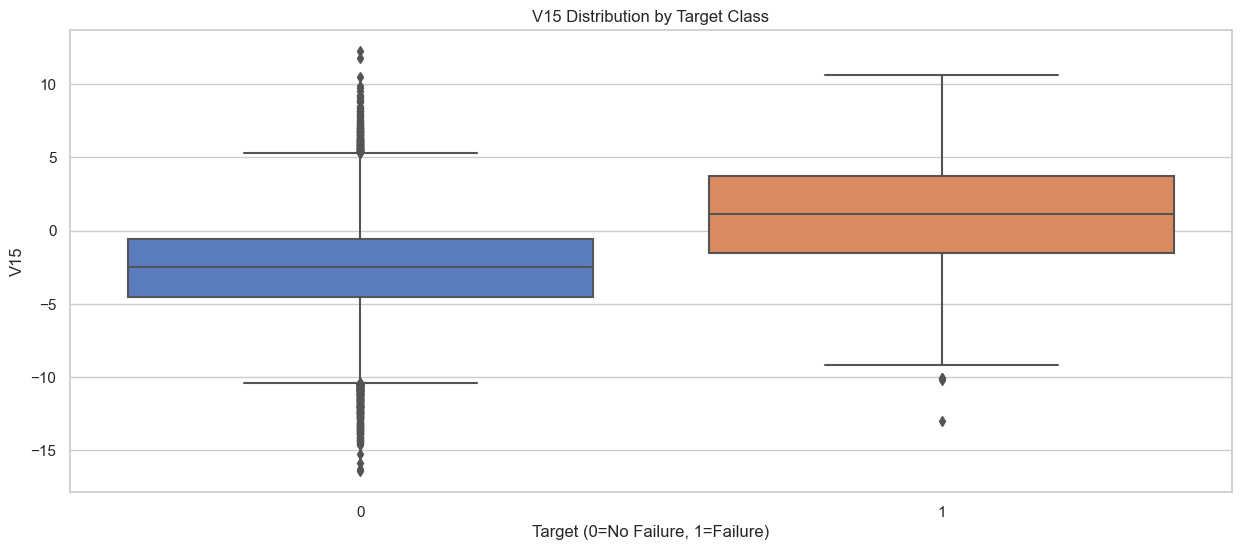

In [93]:
plot_boxplot_by_target(train_df, 'V15')

In [94]:
stats_by_target(train_df, 'V15')

Stats of V15 by target class:
          count  mean  std    min   25%   50%   75%   max
Target                                                   
0      18890.00 -2.62 3.22 -16.42 -4.52 -2.51 -0.59 12.25
1       1110.00  1.03 3.72 -13.00 -1.53  1.13  3.73 10.62


🧐 Observations:

- Spread is slightly wider in class 1 (std 3.72 vs 3.22)
- Overall Range Overlaps, but separation in central tendency is helpful.
- Median for class 0 is -2.51, Median for class 1 is 1.13, Shows that the distribution centers differ.

**This makes V15 a promising feature for neural network modeling**

#### Helper Methods

In [109]:
label_map = {0: 'No Failure', 1: 'Failure'}

In [110]:
# helper for Bivariate Analysis

def bivariate_analysis(df, feature1, feature2, target='Target'):
    """
    Perform bivariate analysis for two numeric features with respect to target class

    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing the data
    feature1 : str
        Name of first feature column
    feature2 : str
        Name of second feature column
    target : str
        Name of target column (default: 'Target')
    """
    color1 = 'steelblue'
    color2 = 'crimson'

    # Scatter plot colored by target class
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=feature1, y=feature2, hue=df[target].map(label_map), data=df, alpha=0.6, palette=[color1, color2])
    plt.title(f'Relationship between {feature1} and {feature2} by Failure Status')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    #plt.legend(title=target, labels=['No Failure', 'Failure'])

    # Add regression lines for each class
    sns.regplot(x=feature1, y=feature2, data=df[df[target]==0],
                scatter=False, ci=None, line_kws={"color":color1, "linestyle":"--"})
    sns.regplot(x=feature1, y=feature2, data=df[df[target]==1],
                scatter=False, ci=None, line_kws={"color":color2, "linestyle":"--"})

    plt.show()

    # Calculate correlation between features for each target class
    print(f"Correlation between {feature1} and {feature2}:")
    print(f"Overall: {df[feature1].corr(df[feature2]):.4f}")
    print(f"No Failure (0): {df[df[target]==0][feature1].corr(df[df[target]==0][feature2]):.4f}")
    print(f"Failure (1): {df[df[target]==1][feature1].corr(df[df[target]==1][feature2]):.4f}")

In [111]:
def plot_kde_bivariate(df, feature1, feature2, target='Target', alpha=0.5, palette='coolwarm'):
    """
    Create a bivariate KDE plot for two features colored by target class.
    """
    sns.kdeplot(data=df, x=feature1, y=feature2, hue=df[target].map(label_map),
                fill=True, alpha=alpha, palette=palette)

In [122]:
from scipy.spatial.distance import pdist, squareform

def quantify_bivariate_distribution(df, feature1, feature2, target='Target'):
    """
    Quantify the bivariate distribution of two features by target class

    This code calculates:
    - Centroids - average position of each class in the feature space
    - Covariance matrices - spread and correlation within each class
    - Bhattacharyya-based overlap - how much the distributions overlap (0=separate, 1=identical)

    (These metrics quantify what you'd visually see in a bivariate KDE plot.)

    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing the data
    feature1, feature2 : str
        Names of feature columns to analyze
    target : str
        Name of target column

    Returns:
    --------
    Dictionary with statistical measures
    """
    results = {}

    # Get data for each class
    class_0 = df[df[target] == 0][[feature1, feature2]].dropna()
    class_1 = df[df[target] == 1][[feature1, feature2]].dropna()

    # 1. Calculate centroids (mean position) for each class
    centroid_0 = class_0.mean()
    centroid_1 = class_1.mean()
    results['centroids'] = {'class_0': centroid_0.to_dict(), 'class_1': centroid_1.to_dict()}

    # 2. Calculate covariance matrices (spread and correlation)
    cov_0 = class_0.cov()
    cov_1 = class_1.cov()
    results['covariance'] = {'class_0': cov_0.values.tolist(), 'class_1': cov_1.values.tolist()}

    # 3. Estimate distribution overlap (simplified approach)
    # Calculate Bhattacharyya distance (smaller means more overlap)

    # Calculate means and covariances
    mean_0 = centroid_0.values
    mean_1 = centroid_1.values
    cov_0_mat = cov_0.values
    cov_1_mat = cov_1.values

    # Average covariance
    cov_avg = (cov_0_mat + cov_1_mat) / 2

    # Calculate Bhattacharyya distance (simplified)
    diff = mean_1 - mean_0
    bhattacharyya = 0.125 * diff.dot(np.linalg.inv(cov_avg)).dot(diff) + 0.5 * np.log(
        np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov_0_mat) * np.linalg.det(cov_1_mat))
    )

    # Convert to overlap measure (0 = no overlap, 1 = complete overlap)
    overlap = np.exp(-bhattacharyya)
    results['overlap'] = overlap

    print("Centroids (mean positions):")
    print(f"Class 0: {results['centroids']['class_0']}")
    print(f"Class 1: {results['centroids']['class_1']}")
    print("\nCovariance matrices:")
    print(f"Class 0:\n{np.array(results['covariance']['class_0'])}")
    print(f"Class 1:\n{np.array(results['covariance']['class_1'])}")
    print(f"\nDistribution overlap: {results['overlap']:.4f} (0=separate, 1=identical)")

    return results

In [128]:
from scipy.stats import pearsonr

def pearson_by_target(df, col1, col2, target_col='Target'):
    print(f"Pearson correlation between '{col1}' and '{col2}':\n")

    # Overall
    r_all, p_all = pearsonr(df[col1], df[col2])
    print(f"Overall:  r = {r_all:.4f},  p-value = {p_all:.4e}")

    # Grouped by target
    for label, group in df.groupby(target_col):
        r, p = pearsonr(group[col1], group[col2])
        print(f"Target {label}: r = {r:.4f},  p-value = {p:.4e}")

#### Features V16 | V21 

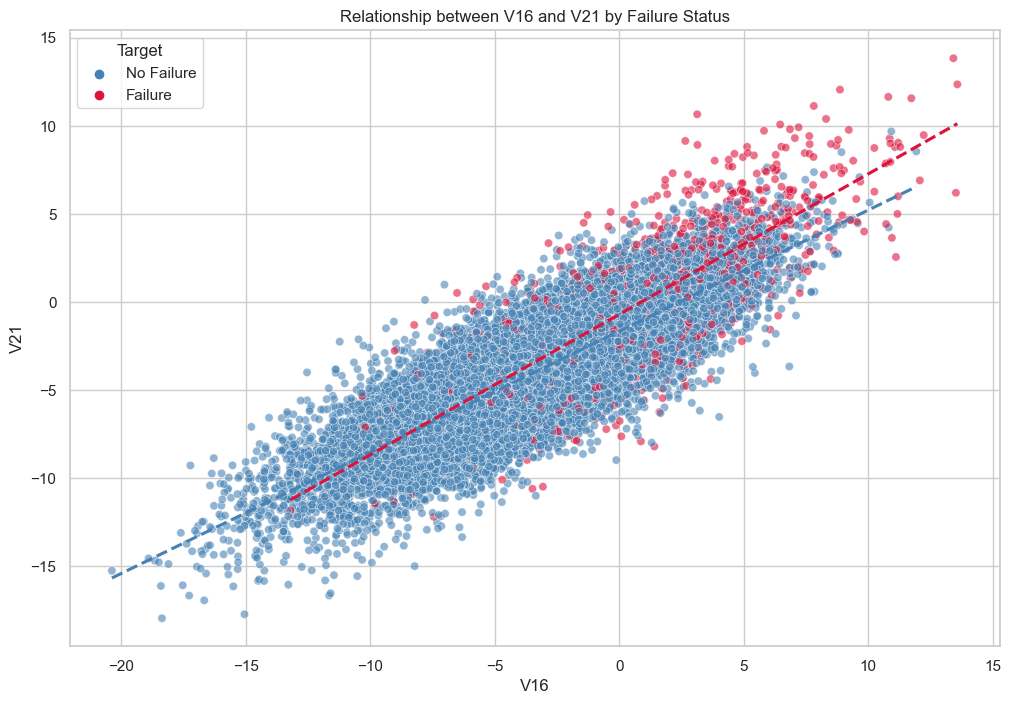

Correlation between V16 and V21:
Overall: 0.8365
No Failure (0): 0.8311
Failure (1): 0.7814


In [112]:
bivariate_analysis(train_df, 'V16', 'V21')

⚡ NOTE: 

**a KDE plot with two numeric columns and binary target as hue shows the density distribution of both classes simultaneously, revealing where failure/non-failure cases concentrate in the 2D feature space. This can highlight separation patterns that might be obscured in scatter plots, especially with overlapping points or large datasets.**

🧠

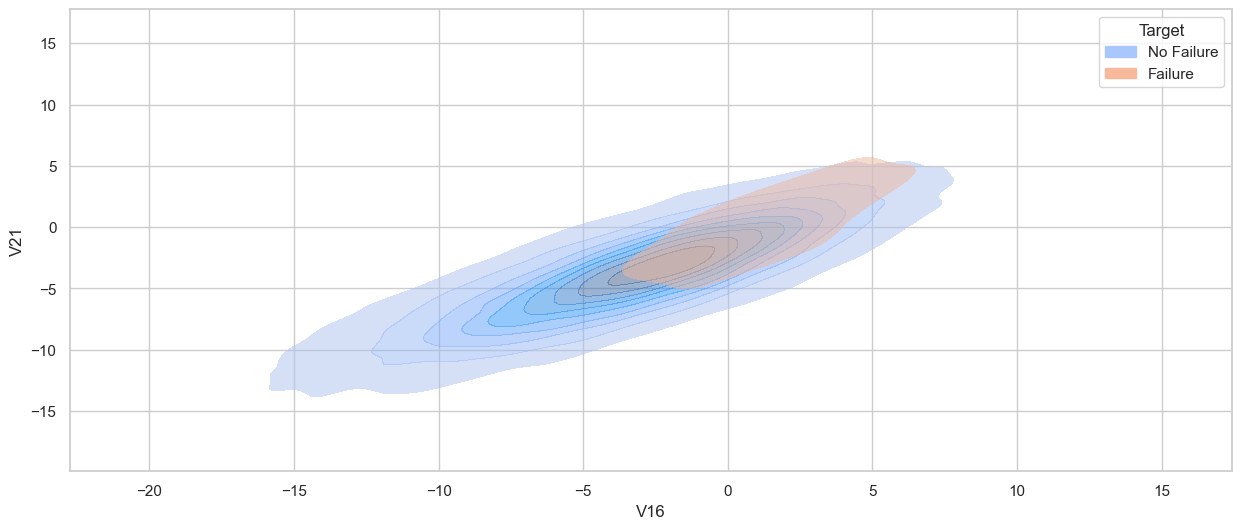

In [113]:
plot_kde_bivariate(train_df, 'V16', 'V21')

👀 Points :

- As it moves away density decreases in outer rings
- Class 1 is concentrated in a specific region of the V16–V21 space, while Class 0 is more widely spread.
- The distribution of class 1 is tighter, possibly making it easier for the model to isolate.
- **But since it's also rare and limited in spread, the model might still struggle to catch it unless guided (e.g. via class weights or sampling).**
- these features carry joint discriminatory power, which is valuable for a neural network to learn from them.

#### Features V14 | V2

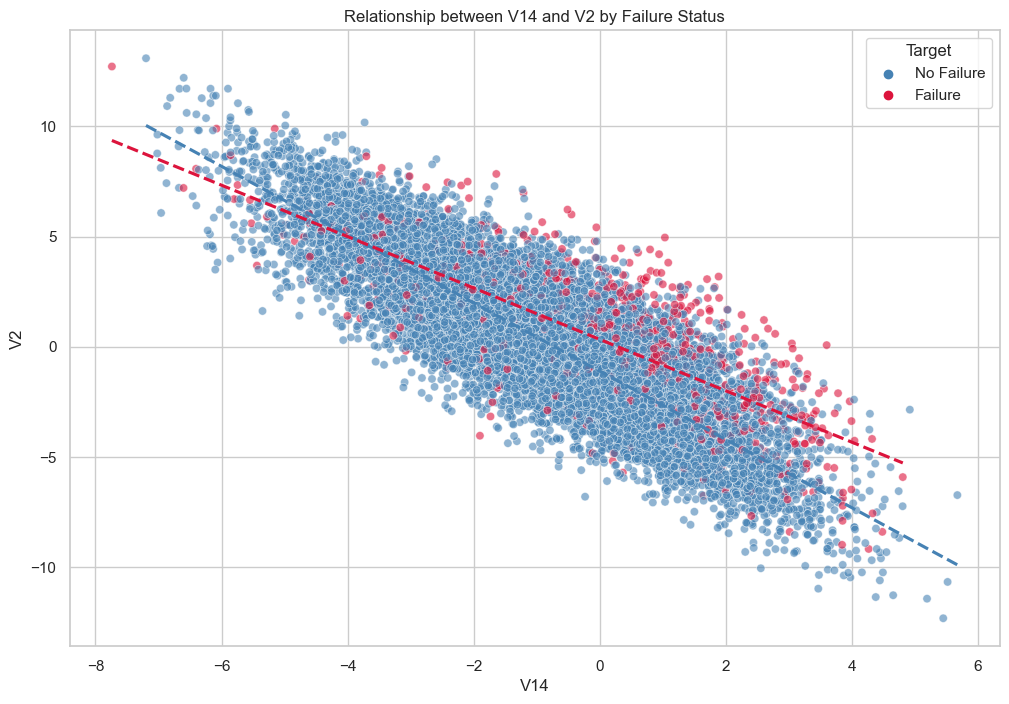

Correlation between V14 and V2:
Overall: -0.8535
No Failure (0): -0.8663
Failure (1): -0.7576


In [114]:
bivariate_analysis(train_df, 'V14', 'V2')

🧐 Observations: 

- as one increases, the other tends to decrease
- Stronger correlation in non-failure cases (-0.8663) than failure cases (-0.7576)
- The weaker correlation in failure cases might represent a deviation from normal operating conditions that could help predict failures.


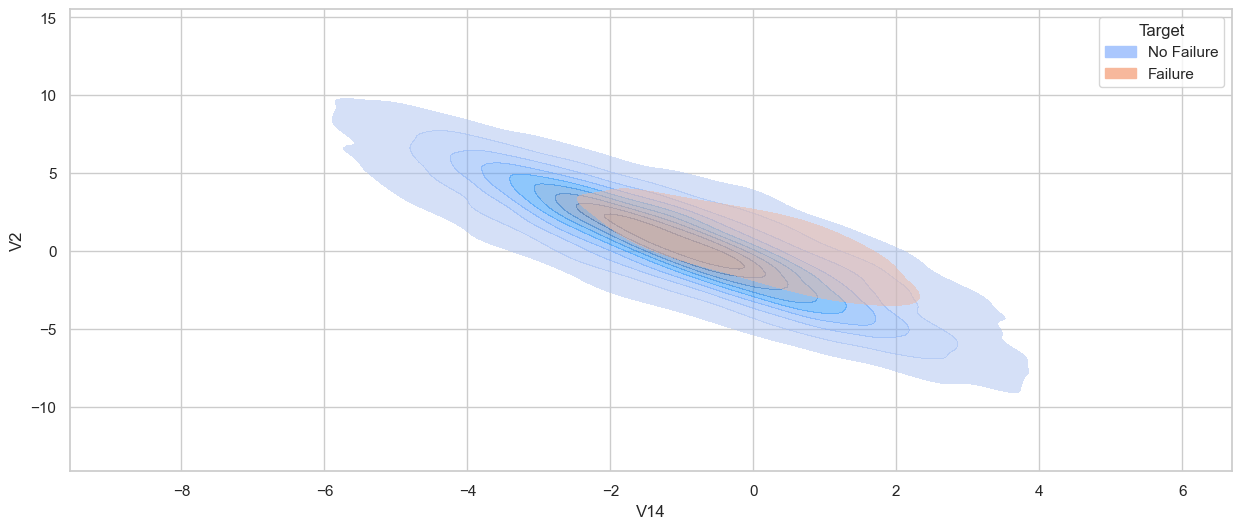

In [115]:
plot_kde_bivariate(train_df, 'V14', 'V2')

In [123]:
quantify_bivariate_distribution(train_df, 'V14', 'V2')

Centroids (mean positions):
Class 0: {'V14': -1.0014655098834253, 'V2': 0.44115253207354815}
Class 1: {'V14': -0.0825361072099099, 'V2': 0.4281430626054054}

Covariance matrices:
Class 0:
[[ 3.11946407 -4.83288728]
 [-4.83288728  9.97750565]]
Class 1:
[[ 3.83336484 -4.47083835]
 [-4.47083835  9.08431959]]

Distribution overlap: 0.8865 (0=separate, 1=identical)


{'centroids': {'class_0': {'V14': -1.0014655098834253,
   'V2': 0.44115253207354815},
  'class_1': {'V14': -0.0825361072099099, 'V2': 0.4281430626054054}},
 'covariance': {'class_0': [[3.119464071012347, -4.832887278745039],
   [-4.832887278745039, 9.977505647252958]],
  'class_1': [[3.833364841615541, -4.4708383467161665],
   [-4.4708383467161665, 9.084319588740449]]},
 'overlap': 0.8864962933154951}

👀 Observations :

- There is some separation between the two classes, especially in those lifted regions — which is good but not sufficient for classification.

#### Feature V15 | V7

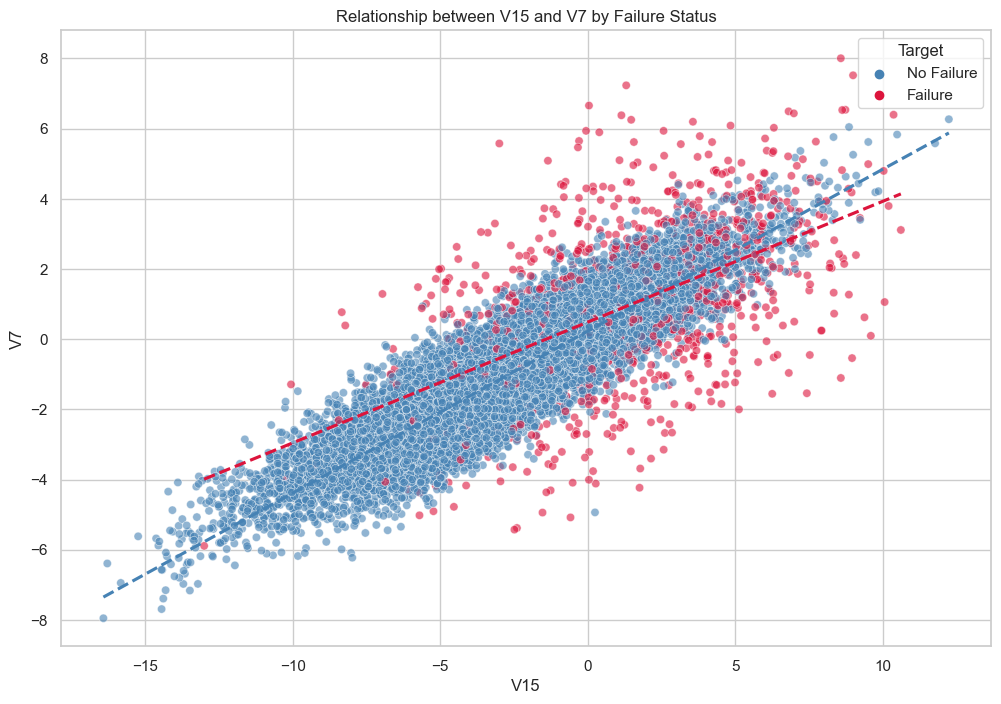

Correlation between V15 and V7:
Overall: 0.8679
No Failure (0): 0.8892
Failure (1): 0.5563


In [124]:
bivariate_analysis(train_df, 'V15', 'V7')

In [129]:
pearson_by_target(train_df, 'V15', 'V7')

Pearson correlation between 'V15' and 'V7':

Overall:  r = 0.8679,  p-value = 0.0000e+00
Target 0: r = 0.8892,  p-value = 0.0000e+00
Target 1: r = 0.5563,  p-value = 3.5184e-91


🧐 Observations :

- Class 0 shows very strong correlation
- class 1, the correlation drops to 0.5563 - still moderate, but noticeably lower.
- Highly significant in both cases (p-values ~ 0) - These patterns are not due to chance

**This dramatic difference in correlation between classes (Δr = 0.33) is extremely valuable for prediction. It suggests that deviations from the normal V15-V7 relationship could be a strong indicator of impending failure.**

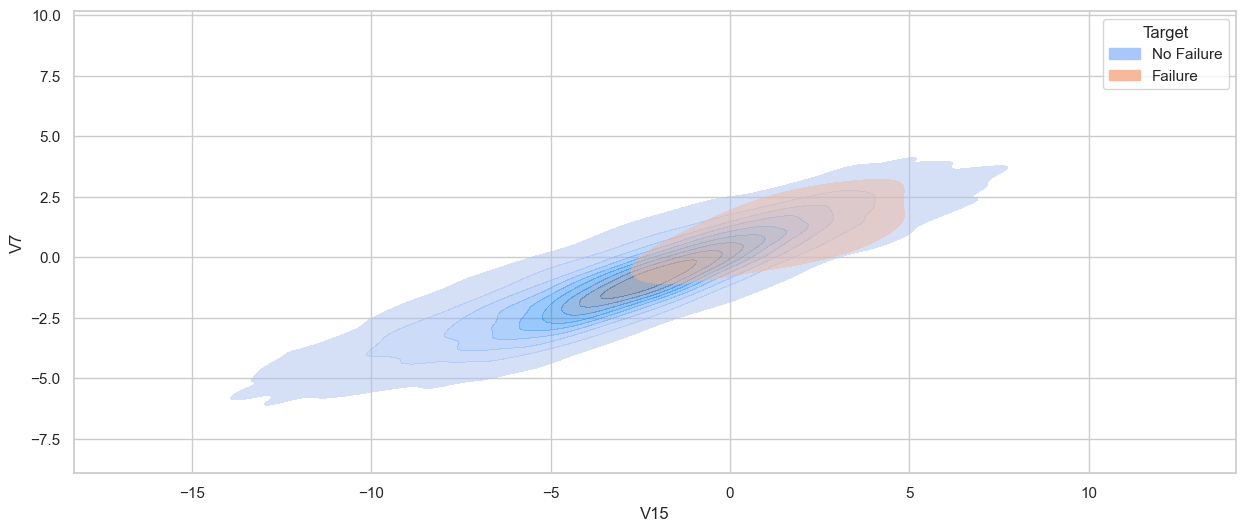

In [130]:
plot_kde_bivariate(train_df, 'V15', 'V7')

#### Features V32 | V24

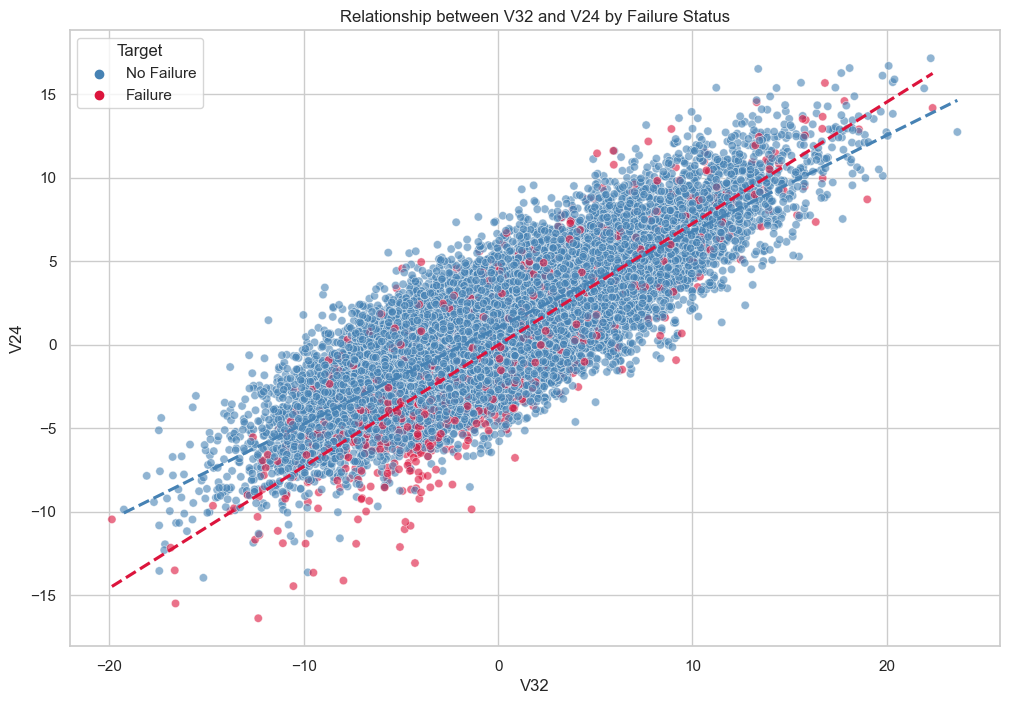

Correlation between V32 and V24:
Overall: 0.8251
No Failure (0): 0.8260
Failure (1): 0.8437


In [131]:
bivariate_analysis(train_df, 'V32', 'V24')

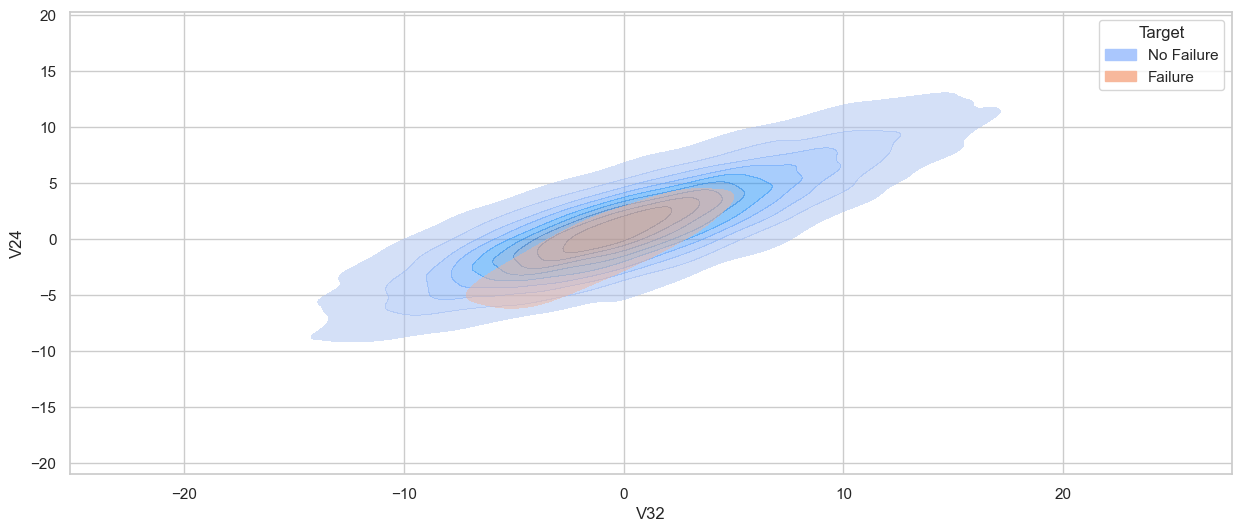

In [132]:
plot_kde_bivariate(train_df, 'V32', 'V24')

🧐 Observations: 

- Consistently strong correlation across all cases (0.83-0.84)
- Minimal difference between classes (Δr = 0.018) - The correlation pattern doesn't change much during failures
- The model may not gain additional discriminatory power just from their interaction.
- As a pair, they don’t offer class-specific signal. Henc, this feature pair is less useful for classification


In [133]:
quantify_bivariate_distribution(train_df, 'V32', 'V24')

Centroids (mean positions):
Class 0: {'V32': 0.34752196286717846, 'V24': 1.2209129419579143}
Class 1: {'V32': -0.44027290951261266, 'V24': -0.3380788756333334}

Covariance matrices:
Class 0:
[[30.09381345 17.3443339 ]
 [17.3443339  14.651877  ]]
Class 1:
[[32.43019054 23.60229324]
 [23.60229324 24.13249914]]

Distribution overlap: 0.9505 (0=separate, 1=identical)


{'centroids': {'class_0': {'V32': 0.34752196286717846,
   'V24': 1.2209129419579143},
  'class_1': {'V32': -0.44027290951261266, 'V24': -0.3380788756333334}},
 'covariance': {'class_0': [[30.09381344806478, 17.34433390181705],
   [17.34433390181705, 14.651876999092396]],
  'class_1': [[32.43019053590661, 23.60229323720998],
   [23.60229323720998, 24.132499141587306]]},
 'overlap': 0.9505219372993786}

⚡ Observation

*The 0.95 overlap score is particularly telling - it means these distributions are nearly identical from a classification perspective, making this feature pair less useful for distinguishing between failure and non-failure cases compared to other pairs we've examined.*

### Feature Exploring | Stats Significance

#### Point-BiSerial Correlation

- For Relating numeric predictors to binary outcomes
- It quantifies both strength and direction of relationships
- It helps identify which features best discriminate between failure/non-failure

For neural network modeling with numeric features and binary classification, this gives us a clear statistical ranking of which features might be most informative.

In [117]:
from scipy.stats import pointbiserialr

# Calculate point-biserial correlation for all numeric features with Target
pb_correlations = {}
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    if col != 'Target':  # Skip the target itself
        # Drop rows with NaN values for this calculation
        valid_data = train_df[[col, 'Target']].dropna()
        if len(valid_data) > 0:  # Make sure we have data after dropping NaNs
            correlation, pvalue = pointbiserialr(valid_data['Target'], valid_data[col])
            pb_correlations[col] = {'correlation': correlation, 'p-value': pvalue}

# Convert to DataFrame and sort by absolute correlation
pb_df = pd.DataFrame.from_dict(pb_correlations, orient='index')
pb_df = pb_df.sort_values(by='correlation', key=abs, ascending=False)

# Display top 10 features by correlation strength
print("Top 10 features by point-biserial correlation with Target:")
display(pb_df.head(10))

Top 10 features by point-biserial correlation with Target:


,correlation,p-value
V18,-0.29,0.00
V21,0.26,0.00
V15,0.25,0.00
V7,0.24,0.00
V16,0.23,0.00
V39,-0.23,0.00
V36,-0.22,0.00
V3,-0.21,0.00
V28,0.21,0.00
V11,0.20,0.00


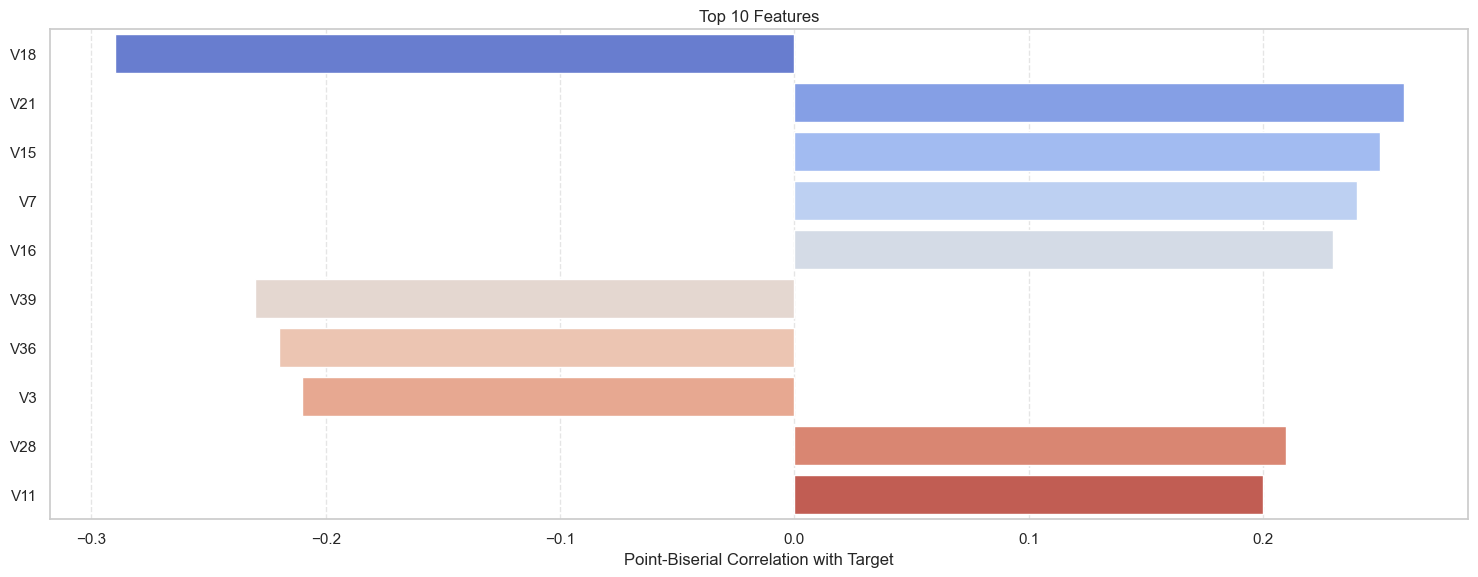

In [134]:
top_features = ['V18', 'V21', 'V15', 'V7', 'V16', 'V39', 'V36', 'V3', 'V28', 'V11']
correlations = [-0.29, 0.26, 0.25, 0.24, 0.23, -0.23, -0.22, -0.21, 0.21, 0.20]

sns.barplot(x=correlations, y=top_features, palette='coolwarm')
plt.xlabel('Point-Biserial Correlation with Target')
plt.title('Top 10 Features')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Common Feature between Potential Predictor and Good Correlated Pair 

[ V14, V2, V18, V21, V15, V7, V16, V11, V8 ]

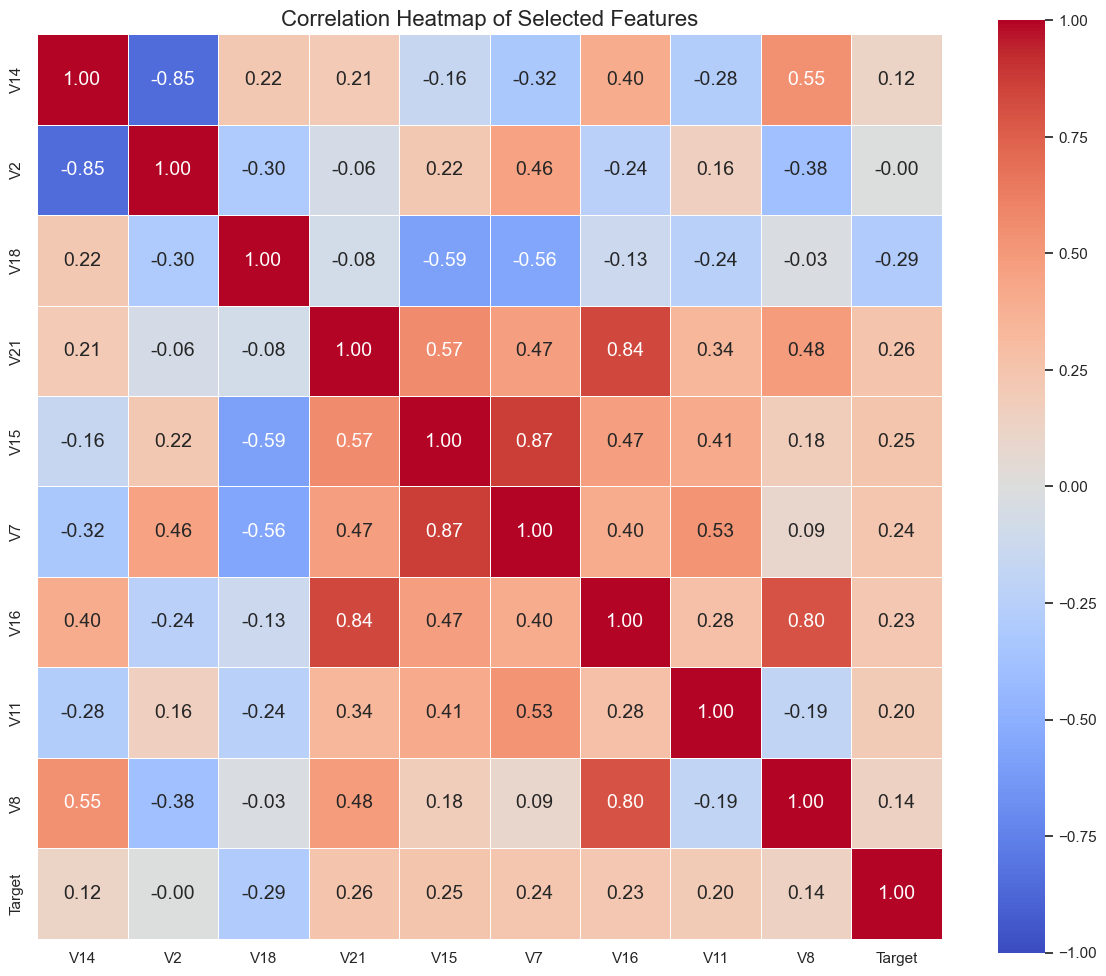

In [135]:
# Create a correlation heatmap for the selected features
selected_features = ['V14', 'V2', 'V18', 'V21', 'V15', 'V7', 'V16', 'V11', 'V8']

# Add Target to see correlations with the target variable
features_with_target = selected_features + ['Target']

# Create correlation matrix
corr_matrix = train_df[features_with_target].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with a color bar
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.title('Correlation Heatmap of Selected Features', fontsize=16)
plt.tight_layout()
plt.show()

In [136]:
corr_matrix

,V14,V2,V18,V21,V15,V7,V16,V11,V8,Target
V14,1.00,-0.85,0.22,0.21,-0.16,-0.32,0.40,-0.28,0.55,0.12
V2,-0.85,1.00,-0.30,-0.06,0.22,0.46,-0.24,0.16,-0.38,-0.00
V18,0.22,-0.30,1.00,-0.08,-0.59,-0.56,-0.13,-0.24,-0.03,-0.29
V21,0.21,-0.06,-0.08,1.00,0.57,0.47,0.84,0.34,0.48,0.26
V15,-0.16,0.22,-0.59,0.57,1.00,0.87,0.47,0.41,0.18,0.25
V7,-0.32,0.46,-0.56,0.47,0.87,1.00,0.40,0.53,0.09,0.24
V16,0.40,-0.24,-0.13,0.84,0.47,0.40,1.00,0.28,0.80,0.23
V11,-0.28,0.16,-0.24,0.34,0.41,0.53,0.28,1.00,-0.19,0.20
V8,0.55,-0.38,-0.03,0.48,0.18,0.09,0.80,-0.19,1.00,0.14
Target,0.12,-0.00,-0.29,0.26,0.25,0.24,0.23,0.20,0.14,1.00


👀 Quick Points

- V14 and V2 have strong negative correlation (r=-0.85)
- V15 and V7 are highly correlated (r=0.87)
- V16 correlates strongly with both V21 (r=0.84) and V8 (r=0.80), forming a cluster of related features

---


## Feature Engineering 

🧠 Neural Net Specific Note:

Even though NN can handle non-linearity, it helps if you scale inputs

In [161]:
# Let reset our pointer to point unaffected df
train_df = train_data.copy()
test_df = test_data.copy()

### Missing Value Treatment

#### Train V1 Imputation

In [162]:
# missing values for V1
print(f"Missing values for V1: {train_df['V1'].isna().sum()}")

Missing values for V1: 18


In [163]:
stats_by_target(train_df, 'V1')

Stats of V1 by target class:
          count  mean  std    min   25%   50%  75%   max
Target                                                  
0      18872.00 -0.33 3.44 -11.88 -2.78 -0.84 1.73 15.49
1       1110.00  0.77 3.38 -10.26 -1.62  0.77 3.10 11.54


⚡ For V1: Class-conditional imputation (since distributions differ by class)

In [164]:
# Class-Wise Imputation Process

# 1. Compute class-wise medians
class_medians = train_df.groupby('Target')['V1'].median()

# 2. Define a row-wise imputation function
def impute_v1(row):
    if pd.isna(row['V1']):
        return class_medians.loc[row['Target']]  # Use median for that class
    return row['V1']  # Keep original value if not missing

# 3. Apply the function row-wise
new_v1 = train_df.apply(impute_v1, axis=1)

In [165]:
# Verify imputation worked correctly

# 1. Count how many values changed
changes = (train_df['V1'] != new_v1).sum()
print(f"Number of values changed: {changes}")

# 2. This should equal the number of missing values we had
original_missing = train_df['V1'].isna().sum()
print(f"Original missing values: {original_missing}")

# 3. Verify they match
print(f"Match: {changes == original_missing}")

Number of values changed: 18
Original missing values: 18
Match: True


In [166]:
# 4: Replace the old V1 column with the new imputed values
train_df['V1'] = new_v1

# 5: Check for missing values again
print(f"Missing values for V1 after imputation: {train_df['V1'].isna().sum()}")


Missing values for V1 after imputation: 0


#### Train V2 Imputation

In [167]:
# missing values for V2
print(f"Missing values for V2: {train_df['V2'].isna().sum()}")

Missing values for V2: 18


In [168]:
stats_by_target(train_df, 'V2')

Stats of V2 by target class:
          count  mean  std    min   25%  50%  75%   max
Target                                                 
0      18872.00  0.44 3.16 -12.32 -1.64 0.47 2.56 13.09
1       1110.00  0.43 3.01  -9.17 -1.60 0.56 2.40 12.72


⚡ For V2: Mean imputation (since distribution is symmetric)

In [169]:
# Global Mean Imputation Process
mean_v2 = train_df['V2'].mean()
old_v2 = train_df['V2'].copy() # just for verification
train_df['V2'].fillna(mean_v2, inplace=True)

In [170]:
# Verify imputation worked correctly
changes = (old_v2 != train_df['V2']).sum()
print(f"Number of values changed: {changes}")

# This should equal the number of missing values we had
original_missing = old_v2.isna().sum()
print(f"Original missing values: {original_missing}")

# Verify they match
print(f"Match: {changes == original_missing}")

Number of values changed: 18
Original missing values: 18
Match: True


In [171]:
# Verify imputation worked correctly
print(f"Missing values for V2 after imputation: {train_df['V2'].isna().sum()}")

Missing values for V2 after imputation: 0


In [172]:
# Totoal missing values for train_df
print(f"Total missing values for train_df: {train_df.isna().sum().sum()}")

Total missing values for train_df: 0


In [160]:
# Find col in test set with missing values
missing_cols = test_df.isna().sum()
missing_cols = missing_cols[missing_cols > 0]
print("Columns with missing values in Test Set:")
print(missing_cols)


Columns with missing values in Test Set:
V1    5
V2    6
dtype: int64


#### Test V1 Imputation

In [173]:
new_v1_test = test_df.apply(impute_v1, axis=1)

In [174]:

# Verify imputation worked correctly
changes = (test_df['V1'] != new_v1_test).sum()
print(f"Number of values changed: {changes}")

# This should equal the number of missing values we had
original_missing = test_df['V1'].isna().sum()
print(f"Original missing values: {original_missing}")

# Verify they match
print(f"Match: {changes == original_missing}")


Number of values changed: 5
Original missing values: 5
Match: True


In [175]:
test_df['V1'] = new_v1_test

# Verify imputation worked correctly
print(f"Missing values for V1 after imputation: {test_df['V1'].isna().sum()}")

Missing values for V1 after imputation: 0


#### Test V2 Imputation

In [176]:
old_v2_test = test_df['V2'].copy()
test_df['V2'].fillna(mean_v2, inplace=True)

# Verify imputation worked correctly
changes = (old_v2_test != test_df['V2']).sum()
print(f"Number of values changed: {changes}")

# This should equal the number of missing values we had
original_missing = old_v2_test.isna().sum()
print(f"Original missing values: {original_missing}")

# Verify they match
print(f"Match: {changes == original_missing}")

Number of values changed: 6
Original missing values: 6
Match: True


In [178]:
# Verify imputation worked correctly
print(f"Missing values for V2 after imputation: {test_df['V2'].isna().sum()}")


Missing values for V2 after imputation: 0


In [183]:
# total missing values for test_df
print(f"Total missing values for test_df: {test_df.isna().sum().sum()}")

Total missing values for test_df: 0


⚠️ **NOTE**: 
We did imputation before Cross-Validation Split

But 

- With very few missing values (like 18/20000 ≈ 0.09%), the impact of slight leakage from imputing before split is negligible.

- Especially since Neural Networks are robust and stochastic in nature, this minor leakage usually doesn't cause measurable harm.

So here safe to impute before split as 
- not using imputation as a learned model step.
- Only 18 missing values — practically noise.


### Train Test Validation Split

⚠️ **NOTE**: 

Since we are manually deriving validations set, 

1. Split data → 2. Fit scaler on training only → 3. Transform all sets

In [185]:
# 1. Split data ---
X = train_df.drop(columns=["Target"])
y = train_df["Target"]
X_test = test_df.drop(columns=["Target"])
y_test = test_df["Target"]

# 2: Train-validation split from training data
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% for validation
    stratify=y,     # For reproducibility
    random_state=42, # Maintain class distribution in both sets
)

In [187]:
# Verify Splits
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (16000, 40)
Validation set size: (4000, 40)
Test set size: (5000, 40)


### Feature Scaling

In [190]:
# Count of negative values in each column
neg_counts = (train_df < 0).sum()

# Filter to show only columns that have at least one negative value
neg_counts = neg_counts[neg_counts > 0]

# Show number of columns with negative values and preview
print(f"Total columns with negative values: {len(neg_counts)}")
neg_counts.sort_values(ascending=False)

Total columns with negative values: 40


V21    17094
V15    15676
V16    15185
V11    14781
V7     14121
V14    13989
V6     13729
V28    13571
V29    13430
V40    12346
V1     11712
V27    11656
V8     10958
V34    10784
V38    10627
V37    10560
V23    10483
V5     10374
V4     10336
V9     10249
V33    10166
V17    10049
V32     9931
V20     9915
V25     9897
V10     9637
V30     9468
V31     8887
V2      8861
V24     7905
V19     7082
V36     6691
V18     6488
V39     6051
V12     5972
V26     5678
V13     5523
V22     5411
V3      4561
V35     4228
dtype: int64

🚀 **Technique picked :- Standardization**

🧠 Why Standardization

- **Neural networks perform better with standardized inputs :**
  Features with mean 0 and standard deviation 1 help gradient-based optimization converge faster

- **All features have negative values :**
  normalization would squash the scale awkwardly and distort relationships.

- **Relative Importance Preserved :**
  Standardization maintains the relative structure and outliers more gracefully than normalization
  
- **Many features show approximately normal distributions  :** 
  Standardization is particularly appropriate for normally distributed data

- **Unknown feature meanings :**
  Without domain knowledge about the features, standardization is a safer default as it's less affected by outliers than min-max scaling

- **Binary classification with neural networks :**
  Standardized features typically work well for this task type


> NOTE: If we didnt do train-test-cv split manually then we may need to perform scaling via pipeline based approach but since cv is done manually we can do scaling here right away before commencing modeling

In [195]:
# Apply Standardization (MANUALLY)

# Fit scaler on training data only
scaler = StandardScaler()
scaler.fit(X_train)

# Transform all datasets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [196]:
# 4. Verify shapes
print(f"Training set: {X_train_scaled.shape}, {y_train.shape}")
print(f"Validation set: {X_val_scaled.shape}, {y_val.shape}")
print(f"Test set: {X_test_scaled.shape}, {y_test.shape}")

Training set: (16000, 40), (16000,)
Validation set: (4000, 40), (4000,)
Test set: (5000, 40), (5000,)


In [197]:
# Print type of scaled data
print(f"Scaled data type: {type(X_train_scaled)}")

Scaled data type: <class 'numpy.ndarray'>


In [200]:
X_train_scaled[0] # 40 dimension numpy array

array([ 0.19992571,  0.54814258,  1.23329038,  0.69415547,  0.43807886,
       -0.81384328, -0.42871372, -0.33970654,  0.20499121,  0.41897356,
       -1.73295281, -0.43442332, -0.69108562, -0.52580544,  0.09618359,
       -0.98062819,  0.8130543 ,  0.09289105,  0.57593636,  0.29088735,
       -0.70300158,  0.18455498, -0.69266221,  0.8760125 ,  0.98465712,
        0.66823053, -0.14014724,  0.36889168, -1.32246639, -1.26577306,
        0.80010054,  0.11719509, -0.68369529,  0.10383149,  0.48283611,
        0.53307755, -0.70013785,  0.04166418,  0.25072397, -0.25832696])

In [201]:
# Step 6: Optionally convert back to DataFrame for compatibility
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_val_scaled_df   = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

In [202]:
X_train_scaled_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40
968,0.20,0.55,1.23,0.69,0.44,-0.81,-0.43,-0.34,0.20,0.42,-1.73,-0.43,-0.69,-0.53,0.10,-0.98,0.81,0.09,0.58,0.29,-0.70,0.18,-0.69,0.88,0.98,0.67,-0.14,0.37,-1.32,-1.27,0.80,0.12,-0.68,0.10,0.48,0.53,-0.70,0.04,0.25,-0.26
7429,0.25,0.04,0.40,-0.35,-0.14,1.06,-0.22,-1.16,0.26,0.83,0.72,-1.15,0.13,-0.20,-0.10,-0.50,-1.33,-0.05,-0.03,-0.89,-0.21,-0.47,-0.99,-0.30,-0.10,0.46,0.69,-0.49,0.25,-0.13,0.39,-0.23,0.94,-0.17,0.34,0.06,-1.02,0.68,0.45,-0.35
10164,0.90,0.93,1.39,0.80,-0.42,-0.10,-0.32,-1.51,1.86,0.01,-0.72,-1.59,0.24,-0.78,-0.23,-1.65,-0.06,-0.62,0.54,0.16,-1.12,-0.24,-1.61,-0.63,1.24,1.11,0.61,-0.08,-0.94,-1.51,-0.14,-0.97,-0.57,0.24,0.27,-0.27,-1.07,0.33,0.43,-0.73
8886,0.03,-0.33,-0.59,-0.57,0.77,-1.01,0.40,1.94,-1.40,-0.54,-0.94,1.67,-0.52,0.71,0.52,1.15,1.21,0.71,-0.71,0.25,0.44,1.04,1.74,1.01,0.11,-0.59,-0.66,-0.04,-0.39,0.21,0.93,0.98,-0.70,-0.73,-0.24,0.68,1.03,-1.10,-0.88,1.32
14435,2.83,0.63,2.27,-1.28,-1.30,-0.36,1.08,-0.62,0.66,0.41,-0.18,0.07,0.61,-0.45,1.13,-0.87,-1.15,-0.97,0.23,-0.79,-1.48,0.17,-1.62,-1.54,2.66,1.02,2.26,-1.64,-0.96,-2.15,1.55,-1.80,-1.35,-0.06,0.58,1.01,-0.94,-0.40,0.48,0.85


### Outliers

- During your EDA, checked for outliers and found that none of the features had more than 5% outliers, which is a common threshold for concern.
- For neural networks, moderate outliers are less problematic than for some other algorithms, especially after standardization.

Post Standardization
- Centered all features around zero
- Scaled them to have unit variance
- Reduced the impact of extreme values

There's no strong need for additional outlier treatment.

Thus we checked for 
1. Missing Data  ✅
2. Data Scaling  ✅
3. Outliers ✅
4. Sampling (Not needed | as of Neural Network Building) 

> Neural networks can often handle class imbalance well, especially if you adjust the loss function (e.g., using class weights) or use appropriate metrics (e.g., precision, recall, F1-score) during training.

Also we dont need encoding target variable as its already possessing 0/1 value (ie Labels expected by Neural Network Output Layer Loss Func comparer by Kera !!)

## Modeling

In [205]:
# Helper Functions

import matplotlib.pyplot as plt

def plot_history(history, metric='loss'):
    """
    Plots the training and validation metrics (loss or accuracy) from the history object.

    Parameters:
    - history: History object from the model training.
    - metric: The metric to plot ('loss' or 'accuracy'). Default is 'loss'.
    """
    # Check if the provided metric is valid
    if metric not in history.history:
        print(f"Error: {metric} not found in history object.")
        return

    # Plot training & validation metrics
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}', color='blue')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}', color='orange')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{metric.capitalize()}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming 'history' is the training history object obtained from model.fit()
# plot_history(history, metric='loss')
# or
# plot_history(history, metric='accuracy')


In [ ]:
import time
import pandas as pd
from tensorflow import keras

# Create empty results dataframes
results = pd.DataFrame(columns=[
    'model_id',
    'hidden_layers',
    'neurons_per_layer',
    'activation',
    'epochs',
    'batch_size',
    'optimizer',
    'learning_rate',
    'momentum',
    'weight_initializer',
    'regularization',
    'train_loss',
    'val_loss',
    'training_time'
])

results_metrics = pd.DataFrame(columns=[
    'model_id',
    'train_recall',
    'val_recall',
    'train_precision',
    'val_precision',
    'train_f2',
    'val_f2',
    'test_recall',
    'test_precision',
    'test_f2',
])

In [207]:
def get_class_weights(y_train):
    labels = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=labels, y=y_train)
    class_weight_dict = dict(zip(labels, class_weights))
    return class_weight_dict

In [3]:
# Helper function to train model and record results
def train_and_evaluate_model(
    X_train,
    y_train,
    X_val,
    y_val,
    hidden_layers=1,
    neurons_per_layer=[16],
    activations=["relu"],
    epochs=50,
    batch_size=32,
    optimizer="adam",
    learning_rate=0.001,
    momentum=0.0,
    weight_initializer="he_normal",
    regularization=None,
    use_batch_norm=False,
    batch_norm_momentum=0.99,
    use_dropout=False,
    dropout_rates=0.2,
    model_id=None,
):
    """
    Train a neural network model and record results (ie Feed Forward NN)

    Parameters:
    -----------
    X_train, y_train: Training data
    X_val, y_val: Validation data
    hidden_layers: Number of hidden layers
    neurons_per_layer: List of neurons for each hidden layer
    activation: Activation function for hidden layers
    epochs: Number of training epochs
    batch_size: Batch size for training
    optimizer: Optimizer ('adam', 'sgd', etc.)
    learning_rate: Learning rate for optimizer
    momentum: Momentum (for SGD)
    weight_initializer: Weight initialization method
    regularization: Regularization method (None, 'l1', 'l2', 'l1_l2')
    use_batch_norm: Boolean or list of booleans for using batch normalization
    batch_norm_momentum: Momentum for batch normalization
    use_dropout: Boolean or list of booleans for using dropout
    dropout_rates: Float or list of floats for dropout rates
    model_id: Identifier for the model

    Returns:
    --------
    model: Trained Keras model
    history: Training history
    """
    global results, results_metrics

    # clears the current keras session, reseting all layers and models previously created, freeing up memory
    keras.backend.clear_session()

    # Generate model ID if not provided
    if model_id is None:
        model_id = f"model_{len(results) + 1}"

    # Input dimension
    input_dim = X_train.shape[1]

    # Convert single values to lists for layer-wise configuration
    if isinstance(use_batch_norm, bool):
        use_batch_norm = [use_batch_norm] * hidden_layers
    if isinstance(use_dropout, bool):
        use_dropout = [use_dropout] * hidden_layers
    if isinstance(dropout_rates, (int, float)):
        # is int or float
        dropout_rates = [dropout_rates] * hidden_layers

    # Create model
    model = keras.Sequential()

    # Input layer
    model.add(keras.layers.Input(shape=(input_dim,)))

    # Hidden layers
    for i in range(hidden_layers):
        # Get activation for this layer (use last one in list if not enough provided)
        layer_activation = activations[i] if i < len(activations) else activations[-1]

        # Get neurons for this layer
        neurons = (
            neurons_per_layer[i]
            if i < len(neurons_per_layer)
            else neurons_per_layer[-1]
        )

        # Add regularization if specified
        if regularization == "l1":
            reg = keras.regularizers.l1(0.01)
        elif regularization == "l2":
            reg = keras.regularizers.l2(0.01)
        elif regularization == "l1_l2":
            reg = keras.regularizers.l1_l2(l1=0.01, l2=0.01)
        else:
            reg = None

        # Flow
        # Dense -> BatchNorm -> Activation -> Dropout

        # Add dense layer (without activation if using batch norm)
        if i < len(use_batch_norm) and use_batch_norm[i]:
            # When using batch norm, add the dense layer without activation
            model.add(
                keras.layers.Dense(
                    neurons,
                    activation=None,  # No activation yet
                    kernel_initializer=weight_initializer,
                    kernel_regularizer=reg,
                )
            )
            # Add batch normalization
            model.add(keras.layers.BatchNormalization(momentum=batch_norm_momentum))
            # Add activation separately (Activation applied after batch norm)
            model.add(keras.layers.Activation(layer_activation))
        else:
            # Standard dense layer with activation
            model.add(
                keras.layers.Dense(
                    neurons,
                    activation=layer_activation,
                    kernel_initializer=weight_initializer,
                    kernel_regularizer=reg,
                )
            )

        # Add dropout if specified for this layer
        if i < len(use_dropout) and use_dropout[i]:
            model.add(keras.layers.Dropout(dropout_rates[i]))

    # Output layer (binary classification)
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    # Configure optimizer
    if optimizer.lower() == "adam":
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer.lower() == "sgd":
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer.lower() == "rmsprop":
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = optimizer

    shout(tag, f"Model ID: {model_id}")
    print(model.summary())

    # Compile model
    model.compile(
        optimizer=opt,
        # Hard coded because we know its binary classification problem
        loss="binary_crossentropy",
        metrics=[
            # predicting a "no failure" when there is actually a failure) is costly,
            keras.metrics.Recall(),
            keras.metrics.Precision(),
            # F2 Score -> missing a failure is very costly, the F2 score provides a better overall evaluation metric than F1.
            keras.metrics.FbetaScore(beta=2.0),
        ],
    )

    # Define class weights for imbalanced data
    # class_weight = {0: 1, 1: (y_train == 0).sum() / (y_train == 1).sum()}

    # Calculate balanced class weights using scikit-learn
    class_weight = get_class_weights(y_train)

    # Record start time
    start_time = time.time()

    shout(tag, "Model Training Started !")

    # Train model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight,
        verbose=1,
    )

    shout(tag, "Model Training Finished !")

    # Calculate training time
    training_time = time.time() - start_time

    # Get final metrics
    train_metrics = model.evaluate(X_train, y_train, verbose=0)
    val_metrics = model.evaluate(X_val, y_val, verbose=0)


    # Extract needed metrics

    # [loss, metric1, metric2, metric3, ...]
    #  |
    # [loss, recall, precision]   // for our case

    train_recall = train_metrics[1]
    val_recall = val_metrics[1]
    train_precision = train_metrics[2]
    val_precision = val_metrics[2]
    train_f2 = train_metrics[3]
    val_f2 = val_metrics[3]

    shout(tag, "Model Training Metrics:")
    shout(tag, "--------------------------------")
    shout(tag, f"Loss: {train_metrics[0]:.2f}")
    shout(tag, "---")
    shout(tag, f"Train Recall: {train_recall:.2f}")
    shout(tag, f"Val Recall: {val_recall:.2f}")
    shout(tag, f"Train Precision: {train_precision:.2f}")
    shout(tag, f"Val Precision: {val_precision:.2f}")
    shout(tag, f"Train F2: {train_f2:.2f}")
    shout(tag, f"Val F2: {val_f2:.2f}")
    shout(tag, "--------------------------------")

    # Record results
    results = results.append(
        {
            "model_id": model_id,
            "hidden_layers": hidden_layers,
            "neurons_per_layer": str(neurons_per_layer),
            "activation": activations,
            "epochs": epochs,
            "batch_size": batch_size,
            "optimizer": optimizer,
            "learning_rate": learning_rate,
            "momentum": momentum,
            "weight_initializer": weight_initializer,
            "regularization": regularization,
            "train_loss": train_metrics[0],
            "val_loss": val_metrics[0],
            "training_time": training_time,
        },
        ignore_index=True,
    )

    results_metrics = results_metrics.append(
        {
            "model_id": model_id,
            "train_recall": train_recall,
            "val_recall": val_recall,
            "train_precision": train_precision,
            "val_precision": val_precision,
            "train_f2": train_f2,
            "val_f2": val_f2,
        },
        ignore_index=True,
    )

    return model, history

In [ ]:
def predict_and_record_test_metrics(model, X_test, y_test, model_id, threshold=0.5):
    """
    Evaluate a model on test data and record metrics in the results dataframes.

    Parameters:
    -----------
    model: Trained Keras model
    X_test: Test features
    y_test: Test labels
    model_id: ID of the model (must match an existing entry in results)
    threshold: Classification threshold (default: 0.5)

    Returns:
    --------
    test_metrics: Dictionary containing calculated test metrics
    """
    global results_metrics

    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > threshold).astype(int)

    # Calculate metrics
    #test_loss = model.evaluate(X_test, y_test, verbose=0)[0]
    test_recall = recall_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_f2 = fbeta_score(y_test, y_pred, beta=2.0)

    # Create metrics dictionary
    test_metrics = {
        'test_recall': test_recall,
        'test_precision': test_precision,
        'test_f2': test_f2
    }

    # Update results_metrics dataframe
    if model_id in results_metrics['model_id'].values:
        idx = results_metrics.index[results_metrics['model_id'] == model_id].tolist()[0]
        results_metrics.at[idx, 'test_recall'] = test_recall
        results_metrics.at[idx, 'test_precision'] = test_precision
        results_metrics.at[idx, 'test_f2'] = test_f2

    # Print resultsw
    shout(tag, f"Test Metrics for Model {model_id} (threshold={threshold}):")
    shout(tag, f"Recall: {test_recall:.2f}")
    shout(tag, f"Precision: {test_precision:.2f}")
    shout(tag, f"F2 Score: {test_f2:.2f}")

    return test_metrics